In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [206]:
plt.rcParams['figure.figsize'] = (15,5)

In [207]:
data = pd.read_csv('data.csv')
print(data.shape)
data.head()

(8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Variable Description
* Item_Identifier - Id продукта
* Item_Weight - Вес продукта
* Item_Fat_Content - Содержание жира в продукте
* Item_Visibility - %полок, отведенный под наш продукт в конкретном магазине
* Item_Type - Категория продукта
* Item_MRP - Максимальная цена продажи продукта
* Outlet_Identifier - Идентификатор магазина
* Outlet_Establishment_Year - Год открытия магазина
* Outlet_Size - Площадь магазина
* Outlet_Location_Type - Тип города, в котором расположен магазин
* Outlet_Type - Признак является ли магазин продуктовым или супермаркетом
* Item_Outlet_Sales - Продажи продукта в конкретном магазине. Именно ее и надо предсказывать

In [548]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Item_Outlet_Sales',1),
                                                   data['Item_Outlet_Sales'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6392, 11), (2131, 11), (6392,), (2131,))

In [209]:
train_data = X_train.copy()
train_data['Item_Outlet_Sales'] = y_train
test_data = X_test.copy()
test_data['Item_Outlet_Sales'] = y_test

# NaNs

In [210]:
s = train_data.isna().sum()
s = s[s>0]
s

Item_Weight    1091
Outlet_Size    1830
dtype: int64

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


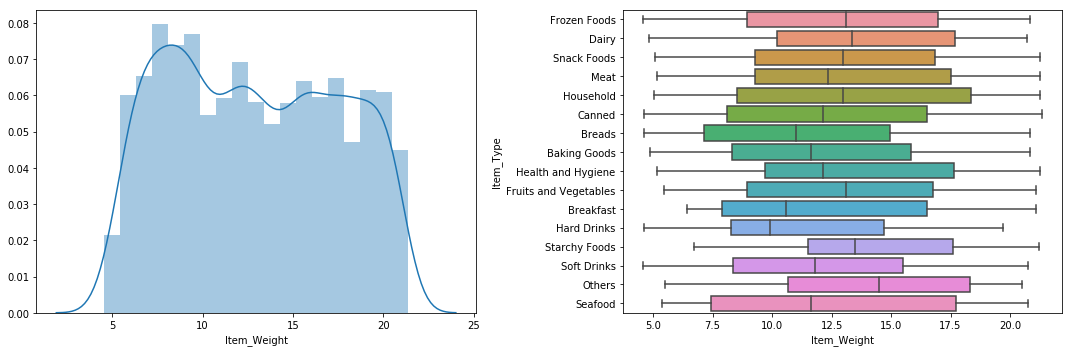

In [211]:
plt.subplot(121)
sns.distplot(train_data['Item_Weight'].dropna())

plt.subplot(122)
sns.boxplot(y='Item_Type',x='Item_Weight', data=train_data)

plt.tight_layout()
plt.show()

Вес всех продуктов распределён равномерно. Но интуитивно, вес продукта должен коррелировать с его типом: хлеб это, мясо или напиток. Поэтому заполним пропуски средним значением веса по типу продукта

In [212]:
d = train_data.groupby("Item_Type")['Item_Weight'].mean().to_dict()
train_data['Item_Weight'] = train_data['Item_Weight'].fillna(train_data['Item_Type'].apply(lambda x: d[x]))
test_data['Item_Weight'] = test_data['Item_Weight'].fillna(test_data['Item_Type'].apply(lambda x: d[x]))

Аналогично, размер магазина должен коррелировать с его типом

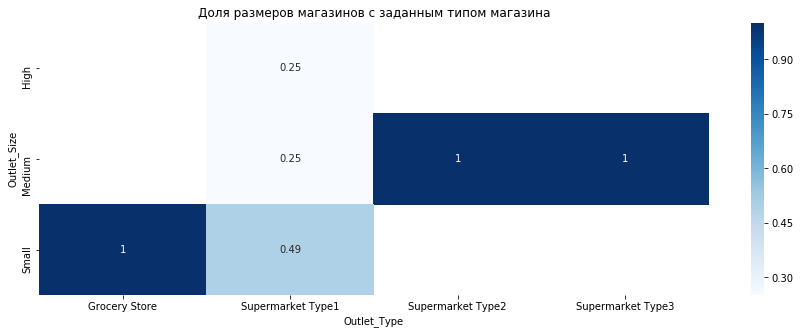

In [213]:
cds = train_data.pivot_table(index='Outlet_Size',columns='Outlet_Type',values='Outlet_Identifier',aggfunc='count')
cds = cds/cds.sum(0)
sns.heatmap(cds, cmap='Blues', annot=True)
plt.title('Доля размеров магазинов с заданным типом магазина');

Исходя из графика, самые вероятные варианты размера магазина:

In [214]:
d = {'Grocery Store':'Small',
     'Supermarket Type1':'Small',
     'Supermarket Type2':'Medium',
     'Supermarket Type3':'Medium',
    }
train_data['Outlet_Size'] = train_data['Outlet_Size'].fillna(train_data['Outlet_Type'].apply(lambda x: d[x]))
test_data['Outlet_Size'] = test_data['Outlet_Size'].fillna(test_data['Outlet_Type'].apply(lambda x: d[x]))

# EDA

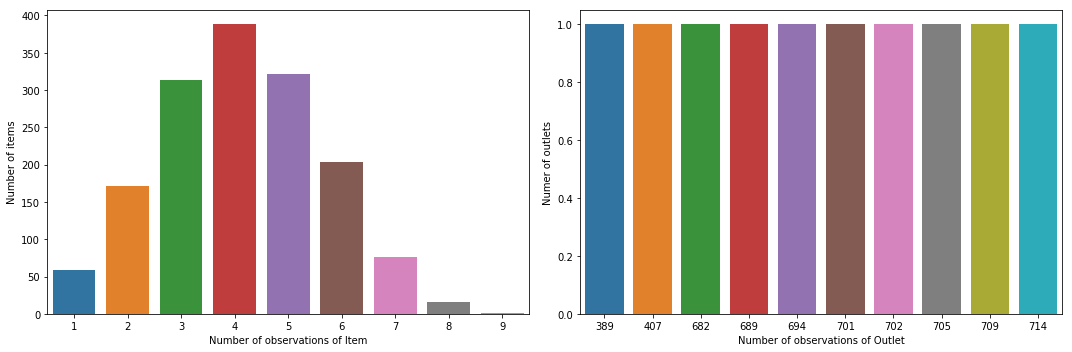

In [215]:
plt.subplot(121)
s = train_data['Item_Identifier'].value_counts().value_counts().sort_index()
sns.barplot(x=s.index, y=s.values)
plt.xlabel('Number of observations of Item')
plt.ylabel('Number of items')

plt.subplot(122)
s = train_data['Outlet_Identifier'].value_counts().value_counts().sort_index()
sns.barplot(x=s.index, y=s.values)
plt.xlabel('Number of observations of Outlet')
plt.ylabel('Numer of outlets')

plt.tight_layout()
plt.show()

В данных очень мало уникальных магазинов и продуктов - поэтому их можно определённым образом использовать в построении модели

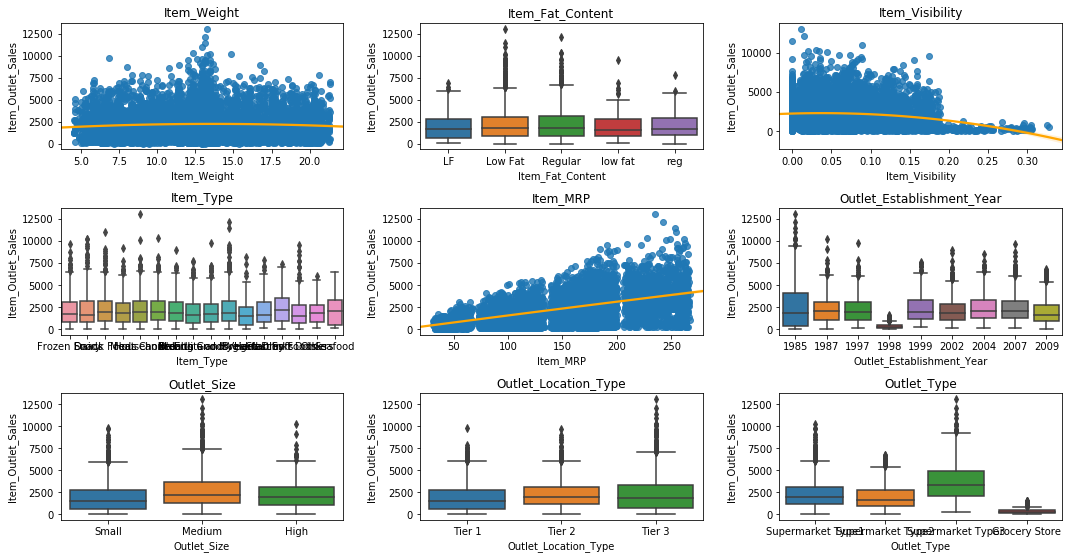

In [216]:
feats = list(data.drop(['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'],1).columns)
plt.figure(figsize=(15,10))
for idx, f in enumerate(feats):
    plt.subplot(len(feats)//3+1, 3, idx+1)
    if train_data[f].nunique()<30:
        sns.boxplot(x=f, y='Item_Outlet_Sales', data=train_data)
    else:
        sns.regplot(x=f, y='Item_Outlet_Sales', data=train_data, line_kws={'color':'orange'}, order=2)
    plt.title(f)

plt.tight_layout()
plt.show()

Что странного и интересного:
* Продукты, под которые отведено много полок плохо продаются. Это очень контринтуитивно
* Чем больше цена - тем больше продаж. Опять, очень странная зависимость
* Магазины 1998 года плохо продают товары. Скорее всего это просто выброс в данных
* Большой разброс продаж приходится на типы магазинов. Нужно посмотреть поподробнее
* Значения жирности продукта можно закодировать числами оставив между ними отношения порядка. То же с outlet_size. С outlet_location_type и outlet_type всё не так просто.
* Много значений жирности дублируют друг друга
* Остальные параметры не показывают ничего интересного

## Item Visibility

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

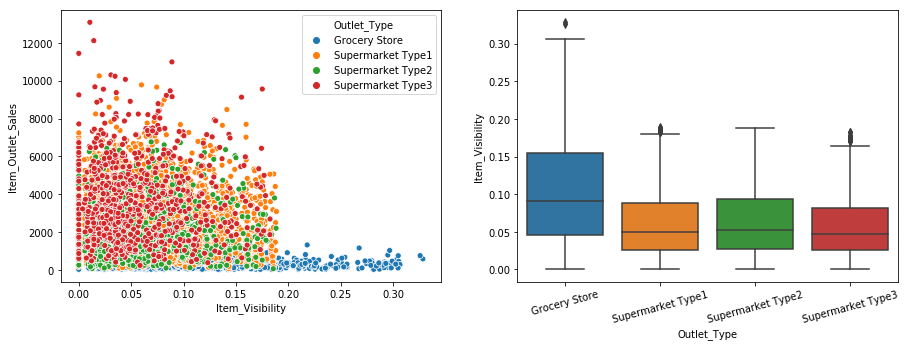

In [217]:
plt.subplot(121)
sns.scatterplot(x='Item_Visibility', y='Item_Outlet_Sales', data=train_data.sort_values('Outlet_Type'), hue='Outlet_Type')

plt.subplot(122)
sns.boxplot(x='Outlet_Type',y='Item_Visibility', data=train_data.sort_values('Outlet_Type'))
plt.xticks(rotation=15)

Товары, для которых отведено много полок продаются плохо по той причине, что они продаются в продуктовых магазинах. Поэтому признак деления на типы магазинов уже должен показать такую зависимость. Но лучше добавить собственный бинарных флаг, выше порога которого все товары продаются только в grocery.

In [218]:
t = train_data[train_data['Outlet_Type']!='Grocery Store']['Item_Visibility'].max()
print(t)
train_data['Big_Visibility_Flag'] = train_data['Item_Visibility']>t
test_data['Big_Visibility_Flag'] = test_data['Item_Visibility']>t

0.188619537


## Item MRP

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


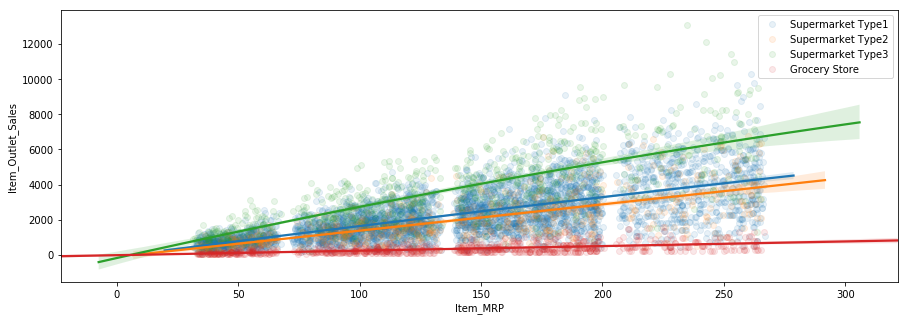

In [219]:
for v in train_data['Outlet_Type'].drop_duplicates().values:
    sns.regplot(x='Item_MRP',y='Item_Outlet_Sales',data=train_data[data['Outlet_Type']==v],
                scatter_kws={'alpha':0.1}, label=v, order=2)
plt.legend()
plt.show()

Товары продаются по разному в разных типах магазинов. Судя по тому, что значения Item_Outlet_Sales - дробные, то это продажи товаров в цене, а не в штуках. Тогда, прямые на графиках должны обозначать количество проданных товаров.

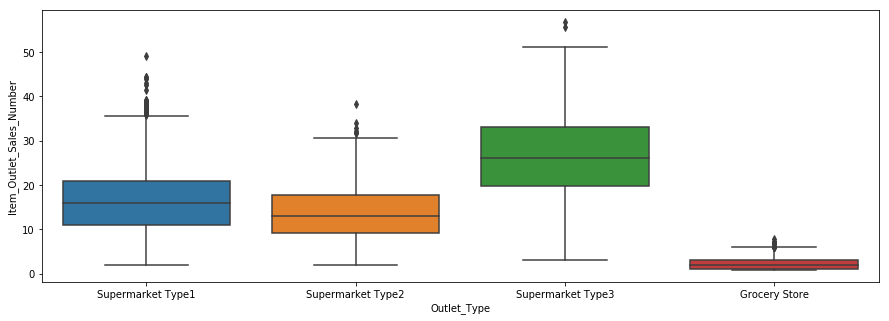

In [220]:
cds = train_data.copy()
cds['Item_Outlet_Sales_Number'] = cds['Item_Outlet_Sales']/cds['Item_MRP']
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales_Number', data=cds)
d = cds.groupby('Outlet_Type')['Item_Outlet_Sales_Number'].mean().to_dict()
train_data['Item_Outlet_Sales_Number'] = train_data['Outlet_Type'].apply(lambda x: d[x])
test_data['Item_Outlet_Sales_Number'] = test_data['Outlet_Type'].apply(lambda x: d[x])

# Item Type

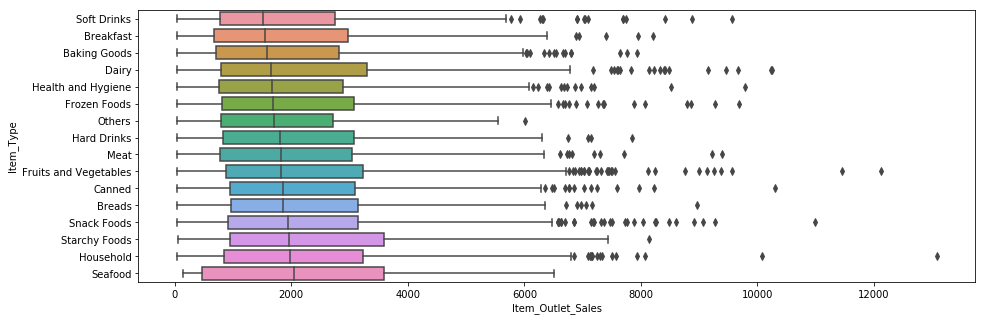

In [221]:
d = data.groupby('Item_Type')['Item_Outlet_Sales'].median().to_dict()
cds = data.copy()
cds['Mean_Sales_Per_Type'] = cds['Item_Type'].apply(lambda x: d[x])
cds = cds.sort_values('Mean_Sales_Per_Type')
sns.boxplot(y='Item_Type', x='Item_Outlet_Sales', data=cds);

Типы продуктов можно объединить по разделам: напитки, для дома, выпечка, быстрое приготовление и т.п. Но можно найти множество разных вариантов объединений - здесь нет какого-либо правильного ответа.

## Outlet Establishment year

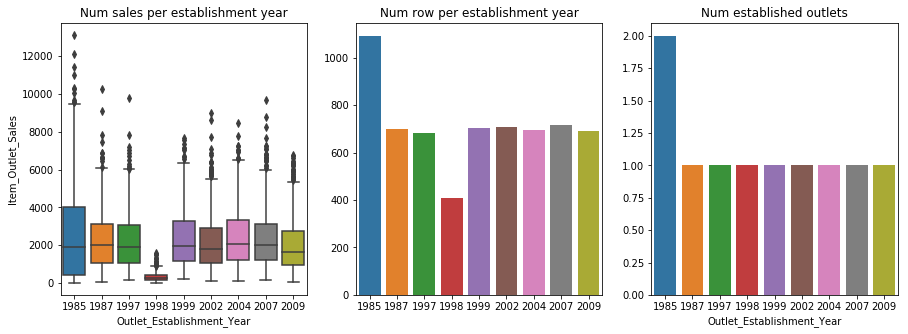

In [222]:
plt.subplot(131)
sns.boxplot(x='Outlet_Establishment_Year', y='Item_Outlet_Sales', data=train_data)
plt.title('Num sales per establishment year')

plt.subplot(132)
s = train_data['Outlet_Establishment_Year'].value_counts().sort_index()
sns.barplot(x=s.index, y=s.values)
plt.title('Num row per establishment year')

plt.subplot(133)
s = train_data.groupby('Outlet_Establishment_Year')['Outlet_Identifier'].nunique().sort_index()
sns.barplot(x=s.index, y=s.values)
plt.title('Num established outlets')


plt.show()

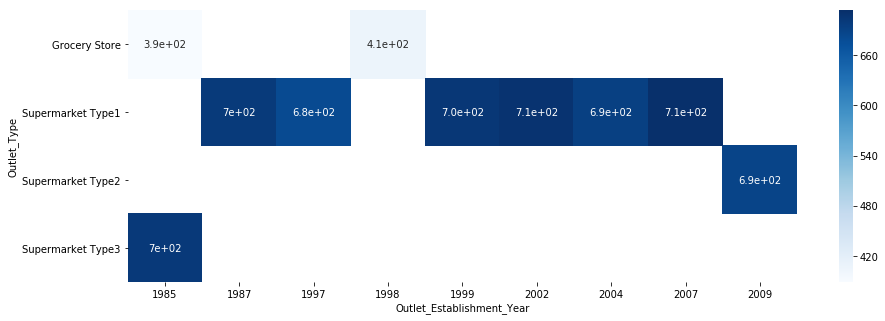

In [223]:
cds = train_data.pivot_table(index='Outlet_Type',columns='Outlet_Establishment_Year',
                       values='Outlet_Identifier', aggfunc='count')
sns.heatmap(cds, cmap='Blues', annot=True);

Причина низких продаж в магазинах, открытых в 1998 году - в том, что они относятся к Grocery Store.

Типы магазинов очень хорошо определяются через год их открытия, поэтому один из этих факторов лучше убрать. Признак года кажется является более сбалансированным по количеству значений, чем тип магазина. Для предсказания будем использовать именно год.

## Item Fat Content

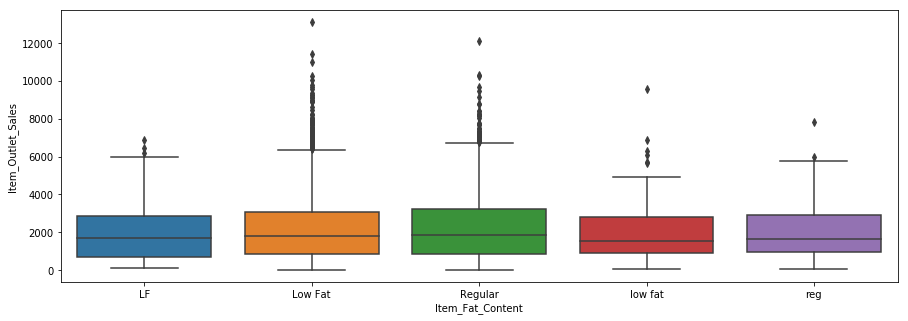

In [224]:
sns.boxplot(x='Item_Fat_Content', y='Item_Outlet_Sales', data=train_data)

Есть всего 2 уникальных значений жирности продукта: Regular и Low. Преобразуем переменную в бинарный признак

In [225]:
train_data['Item_Fat_Content'] = train_data['Item_Fat_Content'].apply(lambda x: 'Regular' if x in ['Regular','reg'] else 'Low')
test_data['Item_Fat_Content'] = test_data['Item_Fat_Content'].apply(lambda x: 'Regular' if x in ['Regular','reg'] else 'Low')

In [228]:
train_data['Regular_Fat_Flag'] = train_data['Item_Fat_Content']=='Regular'
test_data['Regular_Fat_Flag'] = test_data['Item_Fat_Content']=='Regular'

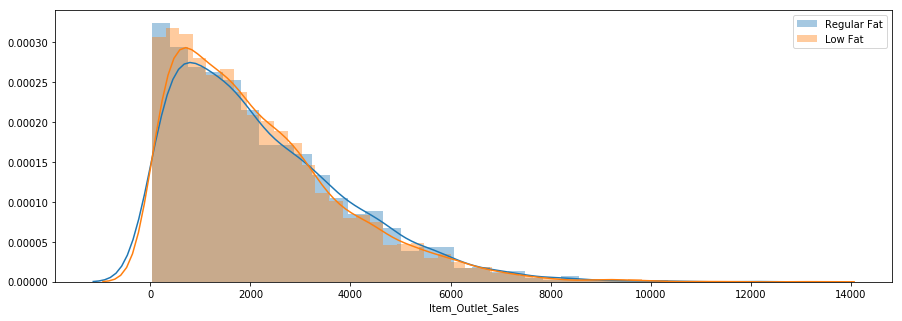

In [229]:
sns.distplot(train_data[train_data['Regular_Fat_Flag']==True]['Item_Outlet_Sales'], label='Regular Fat')
sns.distplot(train_data[train_data['Regular_Fat_Flag']==False]['Item_Outlet_Sales'], label='Low Fat')
plt.legend();

Данные почти не отличаются друг от друга. Но они ещё могут проявить себя при взаимодействии с другими признаками.

## Item Identifier

In [230]:
train_data['Item_Identifier'].head()

3403    FDJ41
5893    DRI51
3715    FDO57
930     FDS51
7849    NCA30
Name: Item_Identifier, dtype: object

Идентификаторы товаров не похожи на простые id. Они могут нести какую-то важную информацию о товаре.

In [231]:
set([x[:2] for x in train_data['Item_Identifier']])

{'DR', 'FD', 'NC'}

In [232]:
print(sorted(set([x[2] for x in train_data['Item_Identifier']]))[:5])
print(len(sorted(set([x[2] for x in train_data['Item_Identifier']]))))

['A', 'B', 'C', 'D', 'E']
26


In [233]:
print(sorted(set([x[3:] for x in train_data['Item_Identifier']]))[:5])
print(len(sorted(set([x[3:] for x in train_data['Item_Identifier']]))))

['01', '02', '03', '04', '05']
60


Первые два символа в идентификаторе похожи на тип товара. Например FD может означать Food.
Затем идёт одна из букв английского алфавита.
Затем одно из чисел от 0 до 60

In [234]:
train_data['Item_Type_Big'] = [x[:2] for x in train_data['Item_Identifier']]
test_data['Item_Type_Big'] = [x[:2] for x in test_data['Item_Identifier']]

## Log

Целевая переменная сильно скошена влево и распределена примерно по логнормальному закону. Поэтому её лучше прологарифмировать и получить нечто похожее на нормальное распределение

In [235]:
train_data['Item_Outlet_Sales_log'] = np.log1p(train_data['Item_Outlet_Sales'])
test_data['Item_Outlet_Sales_log'] = np.log1p(test_data['Item_Outlet_Sales'])

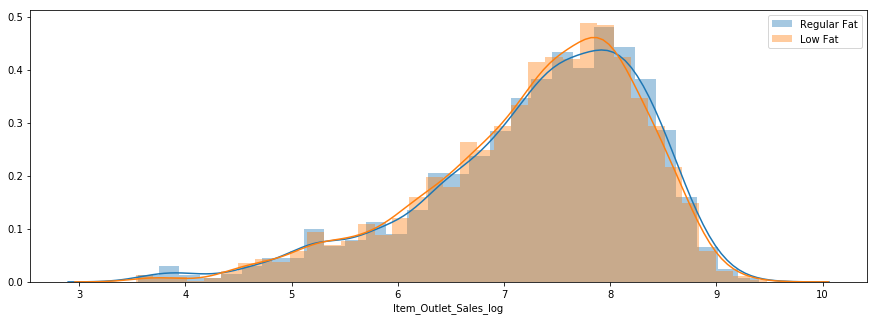

In [236]:
sns.distplot(train_data[train_data['Regular_Fat_Flag']==True]['Item_Outlet_Sales_log'], label='Regular Fat')
sns.distplot(train_data[train_data['Regular_Fat_Flag']==False]['Item_Outlet_Sales_log'], label='Low Fat')
plt.legend();

## Categorial encoding

Разными способами закодируем категориальные факторы

In [237]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

Ordinal Encoding

Переведём категории в числа с сохранением порядка больше/меньше там, где это возможно

In [238]:
d = {'Small':0, 'Medium':1, 'High':2}
train_data['Outlet_Size_Enc'] = train_data['Outlet_Size'].apply(lambda x: d[x])
test_data['Outlet_Size_Enc'] = test_data['Outlet_Size'].apply(lambda x: d[x])

Категориальным признакам на которых нет отношений порядка просто поставим в соответствие какие-нибудь числа

In [239]:
for f in ['Item_Type', 'Item_Type_Big', 'Outlet_Location_Type','Outlet_Type', 'Item_Identifier','Outlet_Identifier']:
    le = LabelEncoder()
    train_data[f+'_Enc'] = le.fit_transform(train_data[f])
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    test_data[f+'_Enc'] = [le_dict.get(x,-1) for x in test_data[f] ]#le.transform(test_data[f],)

Mean Encodings

Средние значения продаж для заданного категориального признака

In [240]:
for f in ['Item_Identifier','Item_Type', 'Item_Type_Big', 'Outlet_Identifier',
          'Outlet_Size','Outlet_Location_Type','Outlet_Type', 'Item_Fat_Content']:
    d = train_data.groupby(f)['Item_Outlet_Sales_log'].mean().to_dict()
    m = train_data['Item_Outlet_Sales_log'].mean()
    train_data[f+'_mean_enc'] = train_data[f].apply(lambda x: d[x])
    test_data[f+'_mean_enc'] = test_data[f].apply(lambda x: d.get(x,m))

One Hot Encodings

In [241]:
for f in ['Outlet_Location_Type','Outlet_Location_Type','Outlet_Type','Item_Type', 'Item_Type_Big']:
    for v in train_data[f].unique():
        train_data[f+'__'+str(v)] = train_data[f]==v
        test_data[f+'__'+str(v)] = test_data[f]==v

## Нормирование признаков

Нормирование необходимо для корректной оценки важности признаков при линейной регрессии, а также для правильной регуляризации

In [338]:
from sklearn.preprocessing import MinMaxScaler

In [337]:
feats_to_scale = train_data.columns[-train_data.dtypes.isin([np.dtype('O'),np.dtype('bool')])]
feats_to_scale

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales',
       'Item_Outlet_Sales_Number', 'Item_Outlet_Sales_log', 'Outlet_Size_Enc',
       'Item_Type_Enc', 'Item_Type_Big_Enc', 'Outlet_Location_Type_Enc',
       'Outlet_Type_Enc', 'Item_Identifier_Enc', 'Outlet_Identifier_Enc',
       'Item_Identifier_mean_enc', 'Item_Type_mean_enc',
       'Item_Type_Big_mean_enc', 'Outlet_Identifier_mean_enc',
       'Outlet_Size_mean_enc', 'Outlet_Location_Type_mean_enc',
       'Outlet_Type_mean_enc', 'Item_Fat_Content_mean_enc'],
      dtype='object')

In [342]:
for f in feats_to_scale:
    scal = MinMaxScaler()
    train_data[f+'_scal'] = scal.fit_transform(train_data[[f]])
    test_data[f+'_scal'] = scal.transform(test_data[[f]])

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all 

# Напоследок проверим корреляцию между признаками

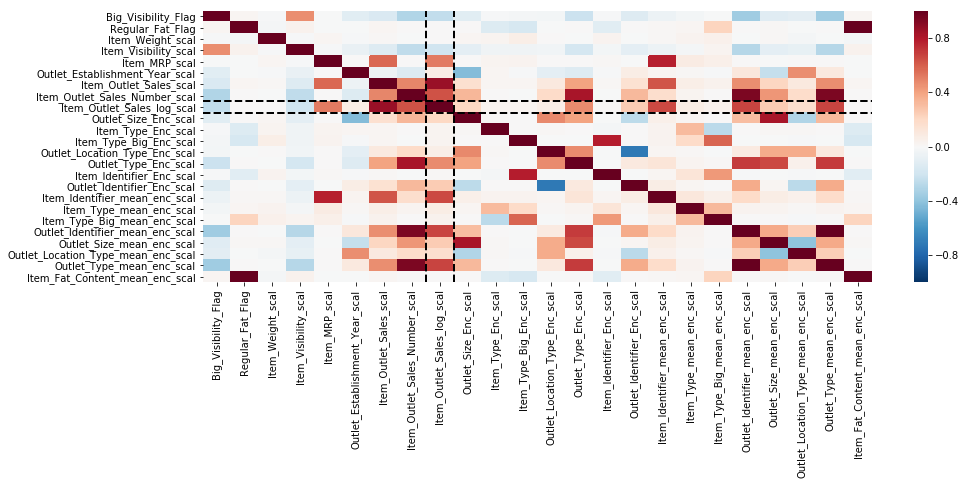

In [345]:
cds = train_data[[x for x in train_data.columns if '__' not in x and x not in feats_to_scale]].corr()
sns.heatmap(cds, cmap='RdBu_r', vmin=-1, vmax=1, annot=False)
for x in [8,9]:
    plt.axvline(x, linestyle='--', color='black', linewidth=2)
    plt.axhline(x, linestyle='--', color='black', linewidth=2)

Многие признаки сильно скоррелированы между собой. Особенно это заметно между mean_encoder'ами для магазинов

# Выбор метрики

Целевая переменная - доходы от продаж продукта - вещественное число. То есть текущая задача - регрессия.

Выбор метрик - MAE, MSE, MAPE, R2

Т.к. будем предсказывать логарифмированное значение продаж, которое имеет порядок единиц, то использование MAPE не принесёт ничего особо интересного.

R2 показывает скорее соответствие угаданной динамики продаж реальной. Нам же в данном случае более важны сами значения продаж.

Поэтому будем использовать метрики MAE, расчитанные как для логарифмированной величины, так и для оригинальной.

Остальные метрики будем расчитывать, но только для справки.

# Построение модели

In [824]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import Pool, CatBoostRegressor
from xgboost import XGBRegressor

In [244]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [245]:
res_ds = pd.DataFrame(columns=['name','mae_train','mae_test','r2_train','r2_test','features'])

In [246]:
def add_model_result(model, model_name, res_ds, train_data, test_data, feats, y_feat='Item_Outlet_Sales_log'):
    X_train = train_data[feats]
    X_test = test_data[feats]
    y_train, y_test = train_data[y_feat], test_data[y_feat]
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    res = {'name':model_name,
           'mae_train': mean_absolute_error(y_train, train_preds),
           'mae_test': mean_absolute_error(y_test, test_preds),
           'r2_train': r2_score(y_train, train_preds),
           'r2_test': r2_score(y_test, test_preds),
           'features':','.join(feats)}
    return res_ds.append(res, ignore_index=True)

## Baseline модели

Попробуем простую линейную модель.

Она не поддерживает категориальные признаки, поэтому передадим ей их кодировки в one-hot encoding и mean encoding

In [362]:
lr_feats = [x for x in train_data if '__' in x] + \
 ['Item_Weight', 'Item_Visibility', 'Item_MRP',
  'Outlet_Establishment_Year', 'Big_Visibility_Flag', 'Item_Outlet_Sales_Number',
  'Regular_Fat_Flag', 'Outlet_Size_Enc',
  'Item_Identifier_mean_enc','Item_Fat_Content_mean_enc','Item_Type_mean_enc', 'Item_Type_Big_mean_enc',
  'Outlet_Identifier_mean_enc','Outlet_Location_Type_mean_enc', 'Outlet_Type_mean_enc', 'Outlet_Size_mean_enc',
  
 ]
y_feat = 'Item_Outlet_Sales_log'

lr_feats = [x+'_scal' if x in feats_to_scale else x for x in lr_feats]

In [391]:
lr = Ridge(random_state=42)
lr.fit(train_data[lr_feats],train_data[y_feat])
res_ds = add_model_result(lr, 'ridge_base', res_ds, train_data, test_data, lr_feats)

Модель посложнее - CatBoost.

Он умеет автоматически обрабатывать категориальные признаки, но shap не поддерживает строковые значения, поэтому категориальные признаки в модель в виде чисел. Для признаков с большим количеством значений catBoost сам делает mean_encoding, но для надежности лучше передать вручную сгенерированные признаки.

In [837]:
cb_feats = ['Item_Identifier_Enc','Item_Weight','Item_Visibility','Item_Type_Enc','Item_MRP','Item_Type_Big_Enc',
           'Outlet_Identifier_Enc','Outlet_Establishment_Year','Outlet_Size_Enc','Outlet_Location_Type_Enc',
           'Outlet_Type_Enc','Big_Visibility_Flag','Item_Outlet_Sales_Number','Regular_Fat_Flag',
           ]+[x for x in train_data.columns if 'mean_enc' in x]
cat_feats = ['Item_Identifier_Enc','Item_Type_Enc', 'Item_Type_Big_Enc',
             'Outlet_Identifier_Enc','Outlet_Location_Type_Enc','Outlet_Type_Enc']
#train_pool = Pool(train_data[cb_feats], train_data[y_feat], cat_features=cat_feats)

In [838]:
cb = CatBoostRegressor(random_state=42,cat_features=cat_feats, verbose=False)
#cb.fit(train_pool, verbose=False, plot=True)
cb.fit(train_data[cb_feats], train_data[y_feat], plot=True)
res_ds = add_model_result(cb, 'cb_base', res_ds, train_data, test_data, cb_feats)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

XGBoost не поддерживает строковые переменные, поэтому передадим ему категориальные признаки в закодированном формате

In [394]:
xgb_feats = ['Item_Identifier_Enc','Item_Weight','Item_Visibility','Item_Type_Enc','Item_MRP', 'Item_Type_Big_Enc',
           'Outlet_Identifier_Enc','Outlet_Establishment_Year','Outlet_Size_Enc','Outlet_Location_Type_Enc',
           'Outlet_Type_Enc','Big_Visibility_Flag','Item_Outlet_Sales_Number','Regular_Fat_Flag',
            ] + [x for x in train_data.columns if '_mean_enc' in x]

In [825]:
xgb = XGBRegressor(random_state=42)
xgb.fit(train_data[xgb_feats], train_data[y_feat])
res_ds = add_model_result(xgb, 'xgb_base', res_ds, train_data, test_data, xgb_feats)

/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[04:58:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


У RandomForest такие же требования к признакам, как и у XGBoost

In [396]:
rf_feats = xgb_feats

In [397]:
rf = RandomForestRegressor(random_state=42)
rf.fit(train_data[rf_feats], train_data[y_feat])
res_ds = add_model_result(rf, 'rf_base', res_ds, train_data, test_data, rf_feats)

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


А у Support Vector - такие же, как у Linear Regression

Сам по себе SVR может быть неинтересен, но позже пригодится в стэкинге моделей для получение более разнородного прогноза базовых моделей

In [398]:
svr_feats = lr_feats

In [365]:
svr = SVR()
svr.fit(train_data[svr_feats], train_data[y_feat])
res_ds = add_model_result(svr, 'svr_base', res_ds, train_data, test_data, svr_feats)

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Grid Search

In [384]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Linear Regression

In [390]:
lr_grid_params = {'alpha':sorted(set(list(np.linspace(1e-2,100,100))+[1])),
                 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
#lr_grid_params

In [387]:
lr_gs = RandomizedSearchCV(Ridge(), lr_grid_params, n_jobs=-1, random_state=42)
lr_gs.fit(train_data[lr_feats], train_data[y_feat])

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'alpha': [0.01, 1, 1.02, 2.03, 3.04, 4.05, 5.06, 6.07, 7.08, 8.09, 9.1, 10.11, 11.12, 12.13, 13.14, 14.15, 15.16, 16.17, 17.180000000000003, 18.19, 19.200000000000003, 20.21, 21.220000000000002, 22.23, 23.240000000000002, 24.250000000000004, 25.26, 26.270000000000003, 27.28, 28....97.98, 98.99000000000001, 100.0], 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [400]:
lr_best = lr_gs.best_estimator_
res_ds = add_model_result(lr_best, 'ridge_best', res_ds, train_data, test_data, lr_feats)

In [401]:
res_ds

,name,mae_train,mae_test,r2_train,r2_test,features
0,ridge_base,0.376042,0.467546,0.773360,0.659476,"Outlet_Location_Type__Tier 1,Outlet_Location_T..."
1,catboost_base,0.372594,0.453490,0.777781,0.678782,"Item_Identifier,Item_Weight,Item_Visibility,It..."
2,xgboost_base,0.409527,0.491013,0.735361,0.630163,"Item_Identifier_Enc,Item_Weight,Item_Visibilit..."
3,rf_base,0.164152,0.489743,0.950083,0.622390,"Item_Identifier_Enc,Item_Weight,Item_Visibilit..."
4,svr_base,0.305952,0.440841,0.818544,0.687324,"Outlet_Location_Type__Tier 1,Outlet_Location_T..."
5,lr_best,0.376042,0.467546,0.773360,0.659476,"Outlet_Location_Type__Tier 1,Outlet_Location_T..."
6,ridge_base,0.375984,0.465440,0.773270,0.662644,"Outlet_Location_Type__Tier 1,Outlet_Location_T..."
7,svr_base,0.372525,0.435501,0.768311,0.696735,"Outlet_Location_Type__Tier 1,Outlet_Location_T..."
8,lr_best,0.376022,0.467115,0.773353,0.660108,"Outlet_Location_Type__Tier 1,Outlet_Location_T..."
9,lr_best,0.376049,0.467527,0.773373,0.659390,"Outlet_Location_Type__Tier 1,Outlet_Location_T..."


Catboost

In [424]:
cb_grid_params = {'learning_rate':list(np.linspace(1e-5,1,100)),
                 'depth':np.linspace(4,16,4).astype(int),
                 'l2_leaf_reg':np.linspace(1e-2,100,10),
                 'cat_features':[cat_feats],
                 'iterations':[10]}
#cb_grid_params

In [420]:
cb_gs = RandomizedSearchCV(CatBoostRegressor(verbose=False), cb_grid_params, n_jobs=-1, random_state=42)
cb_gs.fit(train_data[cb_feats], train_data[y_feat])

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=<catboost.core.CatBoostRegressor object at 0x7f3d8239cc18>,
          fit_params=None, iid='warn', n_iter=10, n_jobs=1,
          param_distributions={'learning_rate': [1e-05, 0.01011090909090909, 0.02021181818181818, 0.030312727272727272, 0.04041363636363637, 0.05051454545454546, 0.06061545454545455, 0.07071636363636363, 0.08081727272727272, 0.09091818181818181, 0.1010190909090909, 0.11112, 0.12122090909090909, 0.131321818181..., 'Item_Type_Big', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Type']], 'iterations': [10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [421]:
cb_best = cb_gs.best_estimator_
res_ds = add_model_result(cb_best, 'cb_best', res_ds, train_data, test_data, cb_feats)

XGBoost

In [429]:
xgb_grid_params = {'max_depth':np.linspace(3,50,5).astype(int),
                  'learning_rate':np.linspace(1e-6,1,10),
                  'n_estimators':np.linspace(10,100,10).astype(int)}
xgb_grid_params

{'max_depth': array([ 3, 14, 26, 38, 50]),
 'learning_rate': array([1.00000e-06, 1.11112e-01, 2.22223e-01, 3.33334e-01, 4.44445e-01,
        5.55556e-01, 6.66667e-01, 7.77778e-01, 8.88889e-01, 1.00000e+00]),
 'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])}

In [430]:
xgb_gs = RandomizedSearchCV(XGBRegressor(verbose=False), xgb_grid_params, n_jobs=-1, random_state=42)
xgb_gs.fit(train_data[xgb_feats], train_data[y_feat])

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:01:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:01:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:01:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:01:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:01:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:01:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:01:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:01:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:01:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:01:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray)

[02:01:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:01:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:01:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:01:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
        colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
        max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
        n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=None, subsample=0.8, verbose=False, verbosity=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=1,
          param_distributions={'max_depth': array([ 3, 14, 26, 38, 50]), 'learning_rate': array([1.00000e-06, 1.11112e-01, 2.22223e-01, 3.33334e-01, 4.44445e-01,
       5.55556e-01, 6.66667e-01, 7.77778e-01, 8.88889e-01, 1.00000e+00]), 'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=

In [431]:
xgb_best = xgb_gs.best_estimator_
res_ds = add_model_result(xgb_best, 'xgb_best', res_ds, train_data, test_data, xgb_feats)

Random Forest

In [438]:
rf_grid_params = {
    'max_depth':np.linspace(3,50,5).astype(int),
    'min_samples_split': np.linspace(1,10,5).astype(int),
    'min_samples_leaf':np.linspace(1,10,5).astype(int),
}

In [441]:
rf_gs = RandomizedSearchCV(RandomForestRegressor(verbose=False), rf_grid_params, n_jobs=-1, random_state=42)
rf_gs.fit(train_data[rf_feats], train_data[y_feat])

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=False,
           warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': array([ 3, 14, 26, 38, 50]), 'min_samples_split': array([ 1,  3,  5,  7, 10]), 'min_samples_leaf': array([ 1,  3,  5,  7, 10])},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [442]:
rf_best = rf_gs.best_estimator_
res_ds = add_model_result(rf_best, 'rf_best', res_ds, train_data, test_data, rf_feats)

SVR

In [456]:
svr_grid_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'degree':np.linspace(1,10,5).astype(int),
                  'gamma':np.linspace(1e-2,1, 10),
                  'C':np.linspace(1e-2,1e2, 10)}

In [457]:
svr_gs = RandomizedSearchCV(SVR(verbose=False), svr_grid_params, n_jobs=-1, random_state=42)
svr_gs.fit(train_data[svr_feats], train_data[y_feat])

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': array([ 1,  3,  5,  7, 10]), 'gamma': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]), 'C': array([1.000e-02, 1.112e+01, 2.223e+01, 3.334e+01, 4.445e+01, 5.556e+01,
       6.667e+01, 7.778e+01, 8.889e+01, 1.000e+02])},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [458]:
svr_best = svr_gs.best_estimator_
res_ds = add_model_result(svr_best, 'svr_best', res_ds, train_data, test_data, svr_feats)

In [462]:
res_ds = res_ds.drop_duplicates()

## Stacking

In [635]:
res_ds.index = res_ds['name']

Выберем лучшие модели каждого класса, из всех, полученных выше

In [636]:
models = [base if res_ds.loc[name+'_base','mae_test']>res_ds.loc[name+'_best','mae_test'] else best
          for base,best,name in zip(
              [lr, cb, xgb, rf, svr],
              [lr_best, cb_best, xgb_best, rf_best, svr_best],
              ['lr','cb','xgb','rf','svr'])]
feats = [lr_feats, cb_feats, xgb_feats, rf_feats, svr_feats]

KeyError: 'the label [lr_base] is not in the [index]'

In [566]:
train_data.shape, test_data.shape

((6392, 80), (2131, 80))

Если поделить обучающий датасет на 2 части: для обучения базовых моделей и для обучения ансамбля, - в каждой из них станет примерно такое же количество строк, сколько и в тесте.

Поэтому для обучения ансамблирующей модели будем использовать предсказания базовых моделей на всём датасете, а чтобы не было переобучения и ни одна базовая модель не предсказывала данные, на которых она обучалась - используем кросс-валидацию

In [567]:
from sklearn.model_selection import KFold

In [703]:
train_stack_data = pd.DataFrame(index = range(len(train_data)), columns=[f'model_{i}' for i in range(len(models))])
test_stack_data = pd.DataFrame(index = range(len(test_data)), columns=[f'model_{i}' for i in range(len(models))])

In [525]:
def train_base_models(models, feats, X,y, cat_feats=None):
    trained_models = []
    for m,fs in tqdm_notebook(zip(models, feats), total=len(models)):
        m.fit(X[fs], y)
        trained_models.append(m)
    return trained_models

In [704]:
for test_idxs, train_idxs in tqdm_notebook(
    KFold(n_splits=10).split(train_data, train_data[y_feat]),
    desc='Going KFolds', total=10,
):
    models = train_base_models(models, feats, train_data.loc[train_idxs], train_data.loc[train_idxs,y_feat], cat_feats)
    train_stack_data.loc[test_idxs] = np.vstack([m.predict(train_data.loc[test_idxs,fs]) for m, fs in zip(models,feats)]).T

0:	learn: 7.1229210	total: 8.77ms	remaining: 8.76s
1:	learn: 6.9143615	total: 10.8ms	remaining: 5.38s
2:	learn: 6.7187678	total: 28.5ms	remaining: 9.47s
3:	learn: 6.5255367	total: 36.7ms	remaining: 9.13s
4:	learn: 6.3350296	total: 43.9ms	remaining: 8.74s
5:	learn: 6.1523248	total: 48.4ms	remaining: 8.02s
6:	learn: 5.9783356	total: 63.3ms	remaining: 8.98s
7:	learn: 5.8042338	total: 65.8ms	remaining: 8.15s
8:	learn: 5.6360719	total: 72.1ms	remaining: 7.93s
9:	learn: 5.4730749	total: 75.6ms	remaining: 7.49s
10:	learn: 5.3150738	total: 77.4ms	remaining: 6.96s
11:	learn: 5.1619006	total: 81ms	remaining: 6.67s
12:	learn: 5.0146124	total: 86.2ms	remaining: 6.54s
13:	learn: 4.8716149	total: 91.4ms	remaining: 6.44s
14:	learn: 4.7341324	total: 100ms	remaining: 6.57s
15:	learn: 4.6066667	total: 107ms	remaining: 6.61s
16:	learn: 4.4786544	total: 114ms	remaining: 6.6s
17:	learn: 4.3578418	total: 121ms	remaining: 6.6s
18:	learn: 4.2331441	total: 123ms	remaining: 6.37s
19:	learn: 4.1118643	total: 125

222:	learn: 0.4754400	total: 795ms	remaining: 2.77s
223:	learn: 0.4750069	total: 798ms	remaining: 2.76s
224:	learn: 0.4747728	total: 800ms	remaining: 2.76s
225:	learn: 0.4747209	total: 802ms	remaining: 2.75s
226:	learn: 0.4744598	total: 807ms	remaining: 2.75s
227:	learn: 0.4738294	total: 817ms	remaining: 2.77s
228:	learn: 0.4736840	total: 820ms	remaining: 2.76s
229:	learn: 0.4732764	total: 827ms	remaining: 2.77s
230:	learn: 0.4732676	total: 830ms	remaining: 2.76s
231:	learn: 0.4728113	total: 838ms	remaining: 2.77s
232:	learn: 0.4728078	total: 839ms	remaining: 2.76s
233:	learn: 0.4722509	total: 841ms	remaining: 2.75s
234:	learn: 0.4720963	total: 844ms	remaining: 2.75s
235:	learn: 0.4716180	total: 848ms	remaining: 2.75s
236:	learn: 0.4716065	total: 849ms	remaining: 2.73s
237:	learn: 0.4713328	total: 853ms	remaining: 2.73s
238:	learn: 0.4711027	total: 856ms	remaining: 2.73s
239:	learn: 0.4710575	total: 857ms	remaining: 2.71s
240:	learn: 0.4710546	total: 858ms	remaining: 2.7s
241:	learn: 0

412:	learn: 0.4463257	total: 1.77s	remaining: 2.52s
413:	learn: 0.4462870	total: 1.78s	remaining: 2.52s
414:	learn: 0.4461346	total: 1.79s	remaining: 2.52s
415:	learn: 0.4459560	total: 1.8s	remaining: 2.53s
416:	learn: 0.4458123	total: 1.81s	remaining: 2.53s
417:	learn: 0.4457999	total: 1.82s	remaining: 2.53s
418:	learn: 0.4456202	total: 1.83s	remaining: 2.53s
419:	learn: 0.4453724	total: 1.83s	remaining: 2.53s
420:	learn: 0.4453395	total: 1.84s	remaining: 2.53s
421:	learn: 0.4451723	total: 1.84s	remaining: 2.52s
422:	learn: 0.4451507	total: 1.85s	remaining: 2.52s
423:	learn: 0.4450048	total: 1.86s	remaining: 2.52s
424:	learn: 0.4449688	total: 1.86s	remaining: 2.52s
425:	learn: 0.4444903	total: 1.87s	remaining: 2.52s
426:	learn: 0.4444683	total: 1.88s	remaining: 2.52s
427:	learn: 0.4443841	total: 1.88s	remaining: 2.52s
428:	learn: 0.4441696	total: 1.89s	remaining: 2.52s
429:	learn: 0.4437857	total: 1.9s	remaining: 2.51s
430:	learn: 0.4437718	total: 1.9s	remaining: 2.51s
431:	learn: 0.4

576:	learn: 0.4305311	total: 2.97s	remaining: 2.18s
577:	learn: 0.4305068	total: 2.98s	remaining: 2.18s
578:	learn: 0.4304907	total: 2.99s	remaining: 2.18s
579:	learn: 0.4304550	total: 3s	remaining: 2.17s
580:	learn: 0.4303820	total: 3.01s	remaining: 2.17s
581:	learn: 0.4303802	total: 3.02s	remaining: 2.17s
582:	learn: 0.4303068	total: 3.03s	remaining: 2.17s
583:	learn: 0.4302020	total: 3.04s	remaining: 2.16s
584:	learn: 0.4301265	total: 3.04s	remaining: 2.16s
585:	learn: 0.4301145	total: 3.05s	remaining: 2.15s
586:	learn: 0.4298135	total: 3.06s	remaining: 2.15s
587:	learn: 0.4297991	total: 3.06s	remaining: 2.15s
588:	learn: 0.4297746	total: 3.07s	remaining: 2.14s
589:	learn: 0.4297575	total: 3.08s	remaining: 2.14s
590:	learn: 0.4297445	total: 3.09s	remaining: 2.14s
591:	learn: 0.4296760	total: 3.1s	remaining: 2.13s
592:	learn: 0.4296148	total: 3.11s	remaining: 2.13s
593:	learn: 0.4294730	total: 3.12s	remaining: 2.13s
594:	learn: 0.4294346	total: 3.13s	remaining: 2.13s
595:	learn: 0.42

763:	learn: 0.4163594	total: 4.35s	remaining: 1.34s
764:	learn: 0.4161850	total: 4.36s	remaining: 1.34s
765:	learn: 0.4161137	total: 4.37s	remaining: 1.33s
766:	learn: 0.4158862	total: 4.38s	remaining: 1.33s
767:	learn: 0.4157989	total: 4.38s	remaining: 1.32s
768:	learn: 0.4157550	total: 4.39s	remaining: 1.32s
769:	learn: 0.4157523	total: 4.4s	remaining: 1.31s
770:	learn: 0.4157496	total: 4.4s	remaining: 1.31s
771:	learn: 0.4157325	total: 4.41s	remaining: 1.3s
772:	learn: 0.4156259	total: 4.41s	remaining: 1.3s
773:	learn: 0.4155499	total: 4.42s	remaining: 1.29s
774:	learn: 0.4155357	total: 4.43s	remaining: 1.28s
775:	learn: 0.4155233	total: 4.43s	remaining: 1.28s
776:	learn: 0.4155101	total: 4.44s	remaining: 1.27s
777:	learn: 0.4154460	total: 4.45s	remaining: 1.27s
778:	learn: 0.4154379	total: 4.45s	remaining: 1.26s
779:	learn: 0.4153946	total: 4.46s	remaining: 1.26s
780:	learn: 0.4153870	total: 4.46s	remaining: 1.25s
781:	learn: 0.4153605	total: 4.47s	remaining: 1.25s
782:	learn: 0.41

939:	learn: 0.4064105	total: 5.51s	remaining: 352ms
940:	learn: 0.4064090	total: 5.52s	remaining: 346ms
941:	learn: 0.4063437	total: 5.53s	remaining: 340ms
942:	learn: 0.4062246	total: 5.53s	remaining: 335ms
943:	learn: 0.4062198	total: 5.54s	remaining: 329ms
944:	learn: 0.4062093	total: 5.55s	remaining: 323ms
945:	learn: 0.4062037	total: 5.56s	remaining: 317ms
946:	learn: 0.4062023	total: 5.56s	remaining: 311ms
947:	learn: 0.4062008	total: 5.56s	remaining: 305ms
948:	learn: 0.4061995	total: 5.56s	remaining: 299ms
949:	learn: 0.4061981	total: 5.56s	remaining: 293ms
950:	learn: 0.4061853	total: 5.57s	remaining: 287ms
951:	learn: 0.4061649	total: 5.58s	remaining: 281ms
952:	learn: 0.4061627	total: 5.58s	remaining: 275ms
953:	learn: 0.4061461	total: 5.59s	remaining: 270ms
954:	learn: 0.4061409	total: 5.6s	remaining: 264ms
955:	learn: 0.4059599	total: 5.6s	remaining: 258ms
956:	learn: 0.4059445	total: 5.61s	remaining: 252ms
957:	learn: 0.4059289	total: 5.62s	remaining: 246ms
958:	learn: 0.

/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:04:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0:	learn: 7.1541391	total: 1.94ms	remaining: 1.94s
1:	learn: 6.9446236	total: 3.75ms	remaining: 1.87s
2:	learn: 6.7422686	total: 6.06ms	remaining: 2.02s
3:	learn: 6.5481665	total: 18.6ms	remaining: 4.62s
4:	learn: 6.3593763	total: 22ms	remaining: 4.38s
5:	learn: 6.1793383	total: 35.9ms	remaining: 5.94s
6:	learn: 6.0002097	total: 38.2ms	remaining: 5.42s
7:	learn: 5.8361259	total: 50ms	remaining: 6.2s
8:	learn: 5.6727048	total: 63ms	remaining: 6.94s
9:	learn: 5.5079032	total: 66.9ms	remaining: 6.63s
10:	learn: 5.3548054	total: 78.4ms	remaining: 7.05s
11:	learn: 5.2039323	total: 85.3ms	remaining: 7.03s
12:	learn: 5.0526801	total: 86.7ms	remaining: 6.58s
13:	learn: 4.9126630	total: 93.8ms	remaining: 6.61s
14:	learn: 4.7775167	total: 101ms	remaining: 6.62s
15:	learn: 4.6431478	total: 105ms	remaining: 6.45s
16:	learn: 4.5092901	total: 108ms	remaining: 6.23s
17:	learn: 4.3793409	total: 110ms	remaining: 6.03s
18:	learn: 4.2564048	total: 113ms	remaining: 5.83s
19:	learn: 4.1356517	total: 116ms	

166:	learn: 0.5247949	total: 586ms	remaining: 2.92s
167:	learn: 0.5239393	total: 588ms	remaining: 2.91s
168:	learn: 0.5229820	total: 598ms	remaining: 2.94s
169:	learn: 0.5217781	total: 609ms	remaining: 2.97s
170:	learn: 0.5209114	total: 614ms	remaining: 2.97s
171:	learn: 0.5200314	total: 618ms	remaining: 2.97s
172:	learn: 0.5195570	total: 620ms	remaining: 2.96s
173:	learn: 0.5190720	total: 621ms	remaining: 2.95s
174:	learn: 0.5189765	total: 623ms	remaining: 2.94s
175:	learn: 0.5185746	total: 625ms	remaining: 2.92s
176:	learn: 0.5177874	total: 632ms	remaining: 2.94s
177:	learn: 0.5168925	total: 639ms	remaining: 2.95s
178:	learn: 0.5160845	total: 643ms	remaining: 2.95s
179:	learn: 0.5151617	total: 646ms	remaining: 2.94s
180:	learn: 0.5148707	total: 648ms	remaining: 2.93s
181:	learn: 0.5138566	total: 652ms	remaining: 2.93s
182:	learn: 0.5131077	total: 654ms	remaining: 2.92s
183:	learn: 0.5120269	total: 658ms	remaining: 2.92s
184:	learn: 0.5119745	total: 659ms	remaining: 2.9s
185:	learn: 0

352:	learn: 0.4726860	total: 1.37s	remaining: 2.51s
353:	learn: 0.4725532	total: 1.38s	remaining: 2.51s
354:	learn: 0.4724201	total: 1.39s	remaining: 2.52s
355:	learn: 0.4722353	total: 1.4s	remaining: 2.52s
356:	learn: 0.4721899	total: 1.4s	remaining: 2.52s
357:	learn: 0.4720324	total: 1.41s	remaining: 2.53s
358:	learn: 0.4717661	total: 1.42s	remaining: 2.53s
359:	learn: 0.4715358	total: 1.42s	remaining: 2.53s
360:	learn: 0.4713054	total: 1.43s	remaining: 2.53s
361:	learn: 0.4711043	total: 1.44s	remaining: 2.53s
362:	learn: 0.4710080	total: 1.44s	remaining: 2.53s
363:	learn: 0.4708451	total: 1.45s	remaining: 2.53s
364:	learn: 0.4708310	total: 1.45s	remaining: 2.53s
365:	learn: 0.4705399	total: 1.46s	remaining: 2.53s
366:	learn: 0.4705148	total: 1.46s	remaining: 2.52s
367:	learn: 0.4703972	total: 1.47s	remaining: 2.52s
368:	learn: 0.4703162	total: 1.47s	remaining: 2.52s
369:	learn: 0.4702891	total: 1.48s	remaining: 2.52s
370:	learn: 0.4701638	total: 1.49s	remaining: 2.52s
371:	learn: 0.

534:	learn: 0.4561398	total: 2.55s	remaining: 2.22s
535:	learn: 0.4561290	total: 2.56s	remaining: 2.22s
536:	learn: 0.4560377	total: 2.57s	remaining: 2.22s
537:	learn: 0.4559269	total: 2.58s	remaining: 2.21s
538:	learn: 0.4558593	total: 2.59s	remaining: 2.22s
539:	learn: 0.4558540	total: 2.59s	remaining: 2.21s
540:	learn: 0.4558448	total: 2.6s	remaining: 2.21s
541:	learn: 0.4558281	total: 2.61s	remaining: 2.2s
542:	learn: 0.4558138	total: 2.61s	remaining: 2.2s
543:	learn: 0.4557956	total: 2.62s	remaining: 2.2s
544:	learn: 0.4555988	total: 2.63s	remaining: 2.19s
545:	learn: 0.4555456	total: 2.63s	remaining: 2.19s
546:	learn: 0.4555336	total: 2.64s	remaining: 2.19s
547:	learn: 0.4555215	total: 2.65s	remaining: 2.18s
548:	learn: 0.4554665	total: 2.65s	remaining: 2.18s
549:	learn: 0.4553983	total: 2.66s	remaining: 2.18s
550:	learn: 0.4553888	total: 2.67s	remaining: 2.17s
551:	learn: 0.4553504	total: 2.67s	remaining: 2.17s
552:	learn: 0.4552613	total: 2.68s	remaining: 2.17s
553:	learn: 0.45

703:	learn: 0.4436042	total: 3.75s	remaining: 1.57s
704:	learn: 0.4434658	total: 3.75s	remaining: 1.57s
705:	learn: 0.4434462	total: 3.76s	remaining: 1.57s
706:	learn: 0.4434360	total: 3.77s	remaining: 1.56s
707:	learn: 0.4434239	total: 3.78s	remaining: 1.56s
708:	learn: 0.4434193	total: 3.79s	remaining: 1.55s
709:	learn: 0.4434151	total: 3.79s	remaining: 1.55s
710:	learn: 0.4433732	total: 3.8s	remaining: 1.54s
711:	learn: 0.4433677	total: 3.81s	remaining: 1.54s
712:	learn: 0.4430558	total: 3.81s	remaining: 1.53s
713:	learn: 0.4430438	total: 3.82s	remaining: 1.53s
714:	learn: 0.4430413	total: 3.83s	remaining: 1.52s
715:	learn: 0.4430283	total: 3.83s	remaining: 1.52s
716:	learn: 0.4430051	total: 3.84s	remaining: 1.51s
717:	learn: 0.4429772	total: 3.85s	remaining: 1.51s
718:	learn: 0.4429696	total: 3.85s	remaining: 1.5s
719:	learn: 0.4428151	total: 3.86s	remaining: 1.5s
720:	learn: 0.4428098	total: 3.87s	remaining: 1.5s
721:	learn: 0.4428046	total: 3.87s	remaining: 1.49s
722:	learn: 0.44

868:	learn: 0.4322904	total: 4.92s	remaining: 743ms
869:	learn: 0.4322265	total: 4.93s	remaining: 737ms
870:	learn: 0.4322221	total: 4.94s	remaining: 732ms
871:	learn: 0.4320989	total: 4.95s	remaining: 727ms
872:	learn: 0.4320523	total: 4.96s	remaining: 722ms
873:	learn: 0.4318641	total: 4.97s	remaining: 717ms
874:	learn: 0.4318516	total: 4.98s	remaining: 711ms
875:	learn: 0.4318488	total: 4.98s	remaining: 705ms
876:	learn: 0.4317494	total: 4.99s	remaining: 699ms
877:	learn: 0.4313756	total: 4.99s	remaining: 694ms
878:	learn: 0.4312160	total: 5s	remaining: 688ms
879:	learn: 0.4312103	total: 5.01s	remaining: 683ms
880:	learn: 0.4309915	total: 5.01s	remaining: 677ms
881:	learn: 0.4309770	total: 5.02s	remaining: 672ms
882:	learn: 0.4308547	total: 5.03s	remaining: 666ms
883:	learn: 0.4308454	total: 5.04s	remaining: 661ms
884:	learn: 0.4306788	total: 5.04s	remaining: 655ms
885:	learn: 0.4304872	total: 5.05s	remaining: 650ms
886:	learn: 0.4304468	total: 5.06s	remaining: 644ms
887:	learn: 0.4

/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:04:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0:	learn: 7.1207150	total: 1.7ms	remaining: 1.7s
1:	learn: 6.9154065	total: 15.9ms	remaining: 7.96s
2:	learn: 6.7261044	total: 34.3ms	remaining: 11.4s
3:	learn: 6.5303151	total: 47.9ms	remaining: 11.9s
4:	learn: 6.3446711	total: 57.8ms	remaining: 11.5s
5:	learn: 6.1599978	total: 60.1ms	remaining: 9.95s
6:	learn: 5.9826163	total: 63.8ms	remaining: 9.05s
7:	learn: 5.8095584	total: 67.9ms	remaining: 8.41s
8:	learn: 5.6424071	total: 70.5ms	remaining: 7.76s
9:	learn: 5.4778854	total: 72.2ms	remaining: 7.15s
10:	learn: 5.3202902	total: 73.8ms	remaining: 6.63s
11:	learn: 5.1674780	total: 81.9ms	remaining: 6.74s
12:	learn: 5.0185808	total: 83ms	remaining: 6.3s
13:	learn: 4.8772903	total: 91.4ms	remaining: 6.43s
14:	learn: 4.7389875	total: 98.7ms	remaining: 6.48s
15:	learn: 4.6093532	total: 107ms	remaining: 6.55s
16:	learn: 4.4811757	total: 115ms	remaining: 6.65s
17:	learn: 4.3573640	total: 123ms	remaining: 6.71s
18:	learn: 4.2336639	total: 125ms	remaining: 6.43s
19:	learn: 4.1136754	total: 126

208:	learn: 0.5090081	total: 792ms	remaining: 3s
209:	learn: 0.5079802	total: 802ms	remaining: 3.02s
210:	learn: 0.5077704	total: 804ms	remaining: 3.01s
211:	learn: 0.5072286	total: 815ms	remaining: 3.03s
212:	learn: 0.5066254	total: 817ms	remaining: 3.02s
213:	learn: 0.5066148	total: 820ms	remaining: 3.01s
214:	learn: 0.5065331	total: 821ms	remaining: 3s
215:	learn: 0.5064101	total: 823ms	remaining: 2.99s
216:	learn: 0.5054715	total: 826ms	remaining: 2.98s
217:	learn: 0.5054493	total: 828ms	remaining: 2.97s
218:	learn: 0.5050886	total: 831ms	remaining: 2.96s
219:	learn: 0.5049724	total: 835ms	remaining: 2.96s
220:	learn: 0.5049596	total: 837ms	remaining: 2.95s
221:	learn: 0.5042438	total: 840ms	remaining: 2.94s
222:	learn: 0.5042377	total: 841ms	remaining: 2.93s
223:	learn: 0.5039241	total: 843ms	remaining: 2.92s
224:	learn: 0.5039187	total: 844ms	remaining: 2.91s
225:	learn: 0.5037990	total: 846ms	remaining: 2.9s
226:	learn: 0.5035943	total: 849ms	remaining: 2.89s
227:	learn: 0.50303

390:	learn: 0.4757223	total: 1.57s	remaining: 2.45s
391:	learn: 0.4757160	total: 1.57s	remaining: 2.44s
392:	learn: 0.4757048	total: 1.58s	remaining: 2.44s
393:	learn: 0.4753306	total: 1.59s	remaining: 2.44s
394:	learn: 0.4748393	total: 1.6s	remaining: 2.45s
395:	learn: 0.4744899	total: 1.61s	remaining: 2.45s
396:	learn: 0.4743905	total: 1.62s	remaining: 2.46s
397:	learn: 0.4743634	total: 1.63s	remaining: 2.46s
398:	learn: 0.4743561	total: 1.63s	remaining: 2.46s
399:	learn: 0.4743488	total: 1.64s	remaining: 2.45s
400:	learn: 0.4743405	total: 1.64s	remaining: 2.44s
401:	learn: 0.4743390	total: 1.64s	remaining: 2.44s
402:	learn: 0.4742954	total: 1.65s	remaining: 2.44s
403:	learn: 0.4742855	total: 1.65s	remaining: 2.43s
404:	learn: 0.4740874	total: 1.66s	remaining: 2.43s
405:	learn: 0.4740547	total: 1.66s	remaining: 2.43s
406:	learn: 0.4740456	total: 1.66s	remaining: 2.42s
407:	learn: 0.4737330	total: 1.67s	remaining: 2.42s
408:	learn: 0.4736957	total: 1.68s	remaining: 2.42s
409:	learn: 0

550:	learn: 0.4638562	total: 2.55s	remaining: 2.08s
551:	learn: 0.4636450	total: 2.56s	remaining: 2.08s
552:	learn: 0.4636389	total: 2.57s	remaining: 2.08s
553:	learn: 0.4636296	total: 2.57s	remaining: 2.07s
554:	learn: 0.4636154	total: 2.59s	remaining: 2.07s
555:	learn: 0.4631641	total: 2.59s	remaining: 2.07s
556:	learn: 0.4631344	total: 2.6s	remaining: 2.07s
557:	learn: 0.4631309	total: 2.6s	remaining: 2.06s
558:	learn: 0.4627873	total: 2.61s	remaining: 2.06s
559:	learn: 0.4627609	total: 2.62s	remaining: 2.06s
560:	learn: 0.4624293	total: 2.63s	remaining: 2.06s
561:	learn: 0.4624234	total: 2.63s	remaining: 2.05s
562:	learn: 0.4624201	total: 2.63s	remaining: 2.04s
563:	learn: 0.4623875	total: 2.64s	remaining: 2.04s
564:	learn: 0.4623402	total: 2.65s	remaining: 2.04s
565:	learn: 0.4622310	total: 2.66s	remaining: 2.04s
566:	learn: 0.4621695	total: 2.67s	remaining: 2.04s
567:	learn: 0.4617804	total: 2.67s	remaining: 2.03s
568:	learn: 0.4616786	total: 2.68s	remaining: 2.03s
569:	learn: 0.

719:	learn: 0.4479904	total: 3.73s	remaining: 1.45s
720:	learn: 0.4479794	total: 3.74s	remaining: 1.45s
721:	learn: 0.4479544	total: 3.75s	remaining: 1.44s
722:	learn: 0.4477858	total: 3.76s	remaining: 1.44s
723:	learn: 0.4473952	total: 3.78s	remaining: 1.44s
724:	learn: 0.4472558	total: 3.78s	remaining: 1.44s
725:	learn: 0.4472403	total: 3.79s	remaining: 1.43s
726:	learn: 0.4472015	total: 3.8s	remaining: 1.43s
727:	learn: 0.4470083	total: 3.81s	remaining: 1.42s
728:	learn: 0.4469948	total: 3.81s	remaining: 1.42s
729:	learn: 0.4469261	total: 3.82s	remaining: 1.41s
730:	learn: 0.4469175	total: 3.83s	remaining: 1.41s
731:	learn: 0.4469175	total: 3.83s	remaining: 1.4s
732:	learn: 0.4468981	total: 3.84s	remaining: 1.4s
733:	learn: 0.4468770	total: 3.84s	remaining: 1.39s
734:	learn: 0.4468746	total: 3.85s	remaining: 1.39s
735:	learn: 0.4468002	total: 3.85s	remaining: 1.38s
736:	learn: 0.4467752	total: 3.86s	remaining: 1.38s
737:	learn: 0.4464089	total: 3.87s	remaining: 1.37s
738:	learn: 0.4

882:	learn: 0.4387371	total: 4.92s	remaining: 651ms
883:	learn: 0.4387276	total: 4.92s	remaining: 646ms
884:	learn: 0.4387150	total: 4.93s	remaining: 641ms
885:	learn: 0.4386194	total: 4.94s	remaining: 636ms
886:	learn: 0.4384858	total: 4.95s	remaining: 630ms
887:	learn: 0.4384755	total: 4.96s	remaining: 626ms
888:	learn: 0.4383581	total: 4.97s	remaining: 620ms
889:	learn: 0.4383408	total: 4.98s	remaining: 615ms
890:	learn: 0.4383402	total: 4.98s	remaining: 609ms
891:	learn: 0.4383303	total: 4.99s	remaining: 604ms
892:	learn: 0.4383232	total: 5s	remaining: 599ms
893:	learn: 0.4383051	total: 5s	remaining: 594ms
894:	learn: 0.4382877	total: 5.01s	remaining: 588ms
895:	learn: 0.4381272	total: 5.02s	remaining: 583ms
896:	learn: 0.4381264	total: 5.03s	remaining: 577ms
897:	learn: 0.4381161	total: 5.04s	remaining: 572ms
898:	learn: 0.4379293	total: 5.04s	remaining: 567ms
899:	learn: 0.4378109	total: 5.05s	remaining: 561ms
900:	learn: 0.4377696	total: 5.06s	remaining: 556ms
901:	learn: 0.4372

/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:04:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0:	learn: 7.1511797	total: 1.75ms	remaining: 1.75s
1:	learn: 6.9447993	total: 19.4ms	remaining: 9.68s
2:	learn: 6.7430110	total: 23.5ms	remaining: 7.8s
3:	learn: 6.5529685	total: 47ms	remaining: 11.7s
4:	learn: 6.3628575	total: 49.9ms	remaining: 9.93s
5:	learn: 6.1791082	total: 56.1ms	remaining: 9.3s
6:	learn: 6.0095215	total: 68.1ms	remaining: 9.66s
7:	learn: 5.8384793	total: 73.6ms	remaining: 9.13s
8:	learn: 5.6691746	total: 74.8ms	remaining: 8.24s
9:	learn: 5.5054594	total: 76.3ms	remaining: 7.55s
10:	learn: 5.3479790	total: 81ms	remaining: 7.29s
11:	learn: 5.1936356	total: 82.2ms	remaining: 6.77s
12:	learn: 5.0432779	total: 84.4ms	remaining: 6.41s
13:	learn: 4.8997063	total: 87.7ms	remaining: 6.18s
14:	learn: 4.7631492	total: 92.2ms	remaining: 6.06s
15:	learn: 4.6331911	total: 100ms	remaining: 6.17s
16:	learn: 4.5003209	total: 103ms	remaining: 5.98s
17:	learn: 4.3729349	total: 107ms	remaining: 5.82s
18:	learn: 4.2487201	total: 109ms	remaining: 5.62s
19:	learn: 4.1283946	total: 110m

204:	learn: 0.5154975	total: 793ms	remaining: 3.08s
205:	learn: 0.5153650	total: 798ms	remaining: 3.07s
206:	learn: 0.5149324	total: 801ms	remaining: 3.07s
207:	learn: 0.5146936	total: 804ms	remaining: 3.06s
208:	learn: 0.5141811	total: 807ms	remaining: 3.05s
209:	learn: 0.5134970	total: 810ms	remaining: 3.04s
210:	learn: 0.5134100	total: 812ms	remaining: 3.04s
211:	learn: 0.5133409	total: 814ms	remaining: 3.02s
212:	learn: 0.5132749	total: 816ms	remaining: 3.01s
213:	learn: 0.5129944	total: 819ms	remaining: 3.01s
214:	learn: 0.5124515	total: 822ms	remaining: 3s
215:	learn: 0.5124432	total: 823ms	remaining: 2.99s
216:	learn: 0.5123825	total: 825ms	remaining: 2.98s
217:	learn: 0.5123544	total: 826ms	remaining: 2.96s
218:	learn: 0.5123263	total: 828ms	remaining: 2.95s
219:	learn: 0.5122985	total: 830ms	remaining: 2.94s
220:	learn: 0.5122923	total: 833ms	remaining: 2.94s
221:	learn: 0.5122792	total: 835ms	remaining: 2.92s
222:	learn: 0.5122737	total: 836ms	remaining: 2.91s
223:	learn: 0.5

392:	learn: 0.4872961	total: 1.57s	remaining: 2.42s
393:	learn: 0.4872790	total: 1.58s	remaining: 2.43s
394:	learn: 0.4872273	total: 1.58s	remaining: 2.42s
395:	learn: 0.4871955	total: 1.59s	remaining: 2.43s
396:	learn: 0.4871748	total: 1.6s	remaining: 2.42s
397:	learn: 0.4871592	total: 1.6s	remaining: 2.42s
398:	learn: 0.4864688	total: 1.61s	remaining: 2.43s
399:	learn: 0.4861447	total: 1.62s	remaining: 2.43s
400:	learn: 0.4861224	total: 1.62s	remaining: 2.43s
401:	learn: 0.4860645	total: 1.63s	remaining: 2.43s
402:	learn: 0.4860163	total: 1.64s	remaining: 2.42s
403:	learn: 0.4858847	total: 1.64s	remaining: 2.42s
404:	learn: 0.4858629	total: 1.65s	remaining: 2.42s
405:	learn: 0.4857428	total: 1.66s	remaining: 2.42s
406:	learn: 0.4856906	total: 1.66s	remaining: 2.42s
407:	learn: 0.4856289	total: 1.67s	remaining: 2.42s
408:	learn: 0.4851480	total: 1.68s	remaining: 2.43s
409:	learn: 0.4850956	total: 1.68s	remaining: 2.42s
410:	learn: 0.4848035	total: 1.69s	remaining: 2.42s
411:	learn: 0.

552:	learn: 0.4670061	total: 2.76s	remaining: 2.23s
553:	learn: 0.4669230	total: 2.78s	remaining: 2.24s
554:	learn: 0.4668709	total: 2.79s	remaining: 2.24s
555:	learn: 0.4666599	total: 2.8s	remaining: 2.24s
556:	learn: 0.4660919	total: 2.81s	remaining: 2.24s
557:	learn: 0.4659112	total: 2.82s	remaining: 2.23s
558:	learn: 0.4659024	total: 2.82s	remaining: 2.23s
559:	learn: 0.4658667	total: 2.83s	remaining: 2.22s
560:	learn: 0.4653692	total: 2.84s	remaining: 2.22s
561:	learn: 0.4653540	total: 2.84s	remaining: 2.21s
562:	learn: 0.4651588	total: 2.85s	remaining: 2.21s
563:	learn: 0.4651470	total: 2.86s	remaining: 2.21s
564:	learn: 0.4651253	total: 2.87s	remaining: 2.21s
565:	learn: 0.4651142	total: 2.87s	remaining: 2.2s
566:	learn: 0.4650991	total: 2.88s	remaining: 2.2s
567:	learn: 0.4647048	total: 2.89s	remaining: 2.19s
568:	learn: 0.4646947	total: 2.89s	remaining: 2.19s
569:	learn: 0.4646169	total: 2.9s	remaining: 2.19s
570:	learn: 0.4645195	total: 2.91s	remaining: 2.18s
571:	learn: 0.46

727:	learn: 0.4469761	total: 4.15s	remaining: 1.55s
728:	learn: 0.4469310	total: 4.16s	remaining: 1.55s
729:	learn: 0.4468665	total: 4.17s	remaining: 1.54s
730:	learn: 0.4468329	total: 4.18s	remaining: 1.54s
731:	learn: 0.4468016	total: 4.19s	remaining: 1.53s
732:	learn: 0.4467688	total: 4.2s	remaining: 1.53s
733:	learn: 0.4465780	total: 4.21s	remaining: 1.52s
734:	learn: 0.4465670	total: 4.22s	remaining: 1.52s
735:	learn: 0.4465643	total: 4.22s	remaining: 1.51s
736:	learn: 0.4465445	total: 4.23s	remaining: 1.51s
737:	learn: 0.4463179	total: 4.24s	remaining: 1.5s
738:	learn: 0.4462383	total: 4.25s	remaining: 1.5s
739:	learn: 0.4462122	total: 4.25s	remaining: 1.5s
740:	learn: 0.4457580	total: 4.26s	remaining: 1.49s
741:	learn: 0.4456589	total: 4.27s	remaining: 1.48s
742:	learn: 0.4456307	total: 4.28s	remaining: 1.48s
743:	learn: 0.4455257	total: 4.29s	remaining: 1.47s
744:	learn: 0.4451473	total: 4.29s	remaining: 1.47s
745:	learn: 0.4451368	total: 4.3s	remaining: 1.46s
746:	learn: 0.445

899:	learn: 0.4364231	total: 5.52s	remaining: 613ms
900:	learn: 0.4364088	total: 5.53s	remaining: 608ms
901:	learn: 0.4363755	total: 5.54s	remaining: 602ms
902:	learn: 0.4363679	total: 5.54s	remaining: 596ms
903:	learn: 0.4363587	total: 5.56s	remaining: 591ms
904:	learn: 0.4363513	total: 5.56s	remaining: 584ms
905:	learn: 0.4363312	total: 5.57s	remaining: 578ms
906:	learn: 0.4363240	total: 5.57s	remaining: 571ms
907:	learn: 0.4362251	total: 5.58s	remaining: 565ms
908:	learn: 0.4361687	total: 5.59s	remaining: 559ms
909:	learn: 0.4361525	total: 5.6s	remaining: 553ms
910:	learn: 0.4361463	total: 5.6s	remaining: 547ms
911:	learn: 0.4360640	total: 5.61s	remaining: 541ms
912:	learn: 0.4360317	total: 5.62s	remaining: 535ms
913:	learn: 0.4359047	total: 5.63s	remaining: 529ms
914:	learn: 0.4359022	total: 5.63s	remaining: 523ms
915:	learn: 0.4358925	total: 5.64s	remaining: 517ms
916:	learn: 0.4357365	total: 5.65s	remaining: 511ms
917:	learn: 0.4357327	total: 5.66s	remaining: 505ms
918:	learn: 0.

/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:04:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0:	learn: 7.1464983	total: 1.82ms	remaining: 1.82s
1:	learn: 6.9383252	total: 7.42ms	remaining: 3.7s
2:	learn: 6.7363193	total: 10.7ms	remaining: 3.56s
3:	learn: 6.5423655	total: 15ms	remaining: 3.73s
4:	learn: 6.3626908	total: 30.2ms	remaining: 6.01s
5:	learn: 6.1767036	total: 33.2ms	remaining: 5.49s
6:	learn: 6.0038103	total: 49ms	remaining: 6.95s
7:	learn: 5.8353739	total: 60.9ms	remaining: 7.55s
8:	learn: 5.6673558	total: 64.6ms	remaining: 7.12s
9:	learn: 5.5054727	total: 69.5ms	remaining: 6.88s
10:	learn: 5.3465999	total: 72.3ms	remaining: 6.5s
11:	learn: 5.2012374	total: 80.1ms	remaining: 6.59s
12:	learn: 5.0553885	total: 89ms	remaining: 6.76s
13:	learn: 4.9101144	total: 90.6ms	remaining: 6.38s
14:	learn: 4.7765266	total: 98.8ms	remaining: 6.49s
15:	learn: 4.6413831	total: 102ms	remaining: 6.25s
16:	learn: 4.5089581	total: 104ms	remaining: 6.01s
17:	learn: 4.3838454	total: 109ms	remaining: 5.93s
18:	learn: 4.2590030	total: 110ms	remaining: 5.67s
19:	learn: 4.1376944	total: 111ms	

202:	learn: 0.5224326	total: 775ms	remaining: 3.04s
203:	learn: 0.5221122	total: 779ms	remaining: 3.04s
204:	learn: 0.5217432	total: 782ms	remaining: 3.03s
205:	learn: 0.5216373	total: 784ms	remaining: 3.02s
206:	learn: 0.5215335	total: 787ms	remaining: 3.01s
207:	learn: 0.5215208	total: 788ms	remaining: 3s
208:	learn: 0.5211920	total: 791ms	remaining: 3s
209:	learn: 0.5211611	total: 794ms	remaining: 2.98s
210:	learn: 0.5205871	total: 798ms	remaining: 2.98s
211:	learn: 0.5198898	total: 808ms	remaining: 3s
212:	learn: 0.5198486	total: 810ms	remaining: 2.99s
213:	learn: 0.5191850	total: 823ms	remaining: 3.02s
214:	learn: 0.5185572	total: 827ms	remaining: 3.02s
215:	learn: 0.5182999	total: 835ms	remaining: 3.03s
216:	learn: 0.5180134	total: 838ms	remaining: 3.02s
217:	learn: 0.5180065	total: 839ms	remaining: 3.01s
218:	learn: 0.5177562	total: 841ms	remaining: 3s
219:	learn: 0.5172901	total: 843ms	remaining: 2.99s
220:	learn: 0.5167330	total: 846ms	remaining: 2.98s
221:	learn: 0.5164111	to

368:	learn: 0.4933031	total: 1.56s	remaining: 2.67s
369:	learn: 0.4932877	total: 1.56s	remaining: 2.66s
370:	learn: 0.4930309	total: 1.57s	remaining: 2.67s
371:	learn: 0.4928541	total: 1.58s	remaining: 2.67s
372:	learn: 0.4927453	total: 1.59s	remaining: 2.67s
373:	learn: 0.4926898	total: 1.6s	remaining: 2.68s
374:	learn: 0.4920892	total: 1.61s	remaining: 2.68s
375:	learn: 0.4920718	total: 1.61s	remaining: 2.67s
376:	learn: 0.4920570	total: 1.61s	remaining: 2.67s
377:	learn: 0.4920474	total: 1.62s	remaining: 2.66s
378:	learn: 0.4915917	total: 1.62s	remaining: 2.66s
379:	learn: 0.4913047	total: 1.63s	remaining: 2.66s
380:	learn: 0.4911725	total: 1.64s	remaining: 2.66s
381:	learn: 0.4909410	total: 1.65s	remaining: 2.66s
382:	learn: 0.4909398	total: 1.65s	remaining: 2.66s
383:	learn: 0.4909253	total: 1.65s	remaining: 2.65s
384:	learn: 0.4909253	total: 1.65s	remaining: 2.64s
385:	learn: 0.4908926	total: 1.66s	remaining: 2.64s
386:	learn: 0.4907503	total: 1.67s	remaining: 2.64s
387:	learn: 0

539:	learn: 0.4743493	total: 2.75s	remaining: 2.35s
540:	learn: 0.4743348	total: 2.76s	remaining: 2.35s
541:	learn: 0.4742241	total: 2.77s	remaining: 2.34s
542:	learn: 0.4741947	total: 2.78s	remaining: 2.34s
543:	learn: 0.4740661	total: 2.79s	remaining: 2.34s
544:	learn: 0.4740640	total: 2.79s	remaining: 2.33s
545:	learn: 0.4739514	total: 2.8s	remaining: 2.33s
546:	learn: 0.4738486	total: 2.81s	remaining: 2.33s
547:	learn: 0.4738072	total: 2.82s	remaining: 2.32s
548:	learn: 0.4735390	total: 2.83s	remaining: 2.32s
549:	learn: 0.4734136	total: 2.83s	remaining: 2.32s
550:	learn: 0.4734001	total: 2.84s	remaining: 2.31s
551:	learn: 0.4733837	total: 2.85s	remaining: 2.31s
552:	learn: 0.4729397	total: 2.85s	remaining: 2.31s
553:	learn: 0.4729060	total: 2.86s	remaining: 2.3s
554:	learn: 0.4728946	total: 2.87s	remaining: 2.3s
555:	learn: 0.4728061	total: 2.88s	remaining: 2.3s
556:	learn: 0.4727602	total: 2.88s	remaining: 2.29s
557:	learn: 0.4727550	total: 2.89s	remaining: 2.29s
558:	learn: 0.47

716:	learn: 0.4582483	total: 4.14s	remaining: 1.63s
717:	learn: 0.4582217	total: 4.15s	remaining: 1.63s
718:	learn: 0.4582204	total: 4.15s	remaining: 1.62s
719:	learn: 0.4582099	total: 4.16s	remaining: 1.62s
720:	learn: 0.4582095	total: 4.16s	remaining: 1.61s
721:	learn: 0.4581817	total: 4.17s	remaining: 1.61s
722:	learn: 0.4580753	total: 4.18s	remaining: 1.6s
723:	learn: 0.4580430	total: 4.19s	remaining: 1.6s
724:	learn: 0.4580363	total: 4.2s	remaining: 1.59s
725:	learn: 0.4580280	total: 4.2s	remaining: 1.58s
726:	learn: 0.4579373	total: 4.21s	remaining: 1.58s
727:	learn: 0.4579079	total: 4.21s	remaining: 1.57s
728:	learn: 0.4575804	total: 4.22s	remaining: 1.57s
729:	learn: 0.4575513	total: 4.23s	remaining: 1.56s
730:	learn: 0.4572308	total: 4.24s	remaining: 1.56s
731:	learn: 0.4569679	total: 4.25s	remaining: 1.55s
732:	learn: 0.4568296	total: 4.25s	remaining: 1.55s
733:	learn: 0.4568263	total: 4.26s	remaining: 1.54s
734:	learn: 0.4567798	total: 4.27s	remaining: 1.54s
735:	learn: 0.45

901:	learn: 0.4490786	total: 5.3s	remaining: 576ms
902:	learn: 0.4490715	total: 5.31s	remaining: 570ms
903:	learn: 0.4490292	total: 5.32s	remaining: 565ms
904:	learn: 0.4490280	total: 5.32s	remaining: 558ms
905:	learn: 0.4490250	total: 5.32s	remaining: 552ms
906:	learn: 0.4490210	total: 5.33s	remaining: 546ms
907:	learn: 0.4490173	total: 5.33s	remaining: 540ms
908:	learn: 0.4488107	total: 5.34s	remaining: 535ms
909:	learn: 0.4487448	total: 5.35s	remaining: 529ms
910:	learn: 0.4487354	total: 5.36s	remaining: 524ms
911:	learn: 0.4487339	total: 5.36s	remaining: 517ms
912:	learn: 0.4487292	total: 5.36s	remaining: 511ms
913:	learn: 0.4486112	total: 5.37s	remaining: 505ms
914:	learn: 0.4486100	total: 5.37s	remaining: 499ms
915:	learn: 0.4486063	total: 5.38s	remaining: 494ms
916:	learn: 0.4485686	total: 5.39s	remaining: 488ms
917:	learn: 0.4485164	total: 5.4s	remaining: 482ms
918:	learn: 0.4485153	total: 5.4s	remaining: 476ms
919:	learn: 0.4484995	total: 5.41s	remaining: 470ms
920:	learn: 0.4

/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0:	learn: 7.1555974	total: 1.8ms	remaining: 1.8s
1:	learn: 6.9490291	total: 23.4ms	remaining: 11.7s
2:	learn: 6.7600967	total: 33.2ms	remaining: 11s
3:	learn: 6.5653513	total: 48.4ms	remaining: 12s
4:	learn: 6.3726522	total: 58.6ms	remaining: 11.7s
5:	learn: 6.1876444	total: 60.8ms	remaining: 10.1s
6:	learn: 6.0124955	total: 71.9ms	remaining: 10.2s
7:	learn: 5.8400909	total: 78.1ms	remaining: 9.68s
8:	learn: 5.6725009	total: 80.2ms	remaining: 8.83s
9:	learn: 5.5138365	total: 93.6ms	remaining: 9.27s
10:	learn: 5.3548635	total: 95.2ms	remaining: 8.56s
11:	learn: 5.2060951	total: 103ms	remaining: 8.49s
12:	learn: 5.0613784	total: 111ms	remaining: 8.46s
13:	learn: 4.9242675	total: 119ms	remaining: 8.41s
14:	learn: 4.7872097	total: 124ms	remaining: 8.17s
15:	learn: 4.6507936	total: 129ms	remaining: 7.93s
16:	learn: 4.5171342	total: 130ms	remaining: 7.52s
17:	learn: 4.3935462	total: 138ms	remaining: 7.53s
18:	learn: 4.2672430	total: 140ms	remaining: 7.24s
19:	learn: 4.1466457	total: 143ms	re

193:	learn: 0.4900456	total: 784ms	remaining: 3.26s
194:	learn: 0.4897179	total: 787ms	remaining: 3.25s
195:	learn: 0.4885188	total: 797ms	remaining: 3.27s
196:	learn: 0.4883840	total: 802ms	remaining: 3.27s
197:	learn: 0.4883574	total: 806ms	remaining: 3.26s
198:	learn: 0.4883313	total: 808ms	remaining: 3.25s
199:	learn: 0.4878430	total: 823ms	remaining: 3.29s
200:	learn: 0.4872448	total: 828ms	remaining: 3.29s
201:	learn: 0.4871133	total: 829ms	remaining: 3.27s
202:	learn: 0.4867127	total: 831ms	remaining: 3.26s
203:	learn: 0.4862058	total: 833ms	remaining: 3.25s
204:	learn: 0.4860712	total: 835ms	remaining: 3.24s
205:	learn: 0.4860499	total: 837ms	remaining: 3.23s
206:	learn: 0.4860086	total: 838ms	remaining: 3.21s
207:	learn: 0.4859939	total: 839ms	remaining: 3.2s
208:	learn: 0.4858724	total: 842ms	remaining: 3.19s
209:	learn: 0.4858532	total: 844ms	remaining: 3.17s
210:	learn: 0.4856908	total: 848ms	remaining: 3.17s
211:	learn: 0.4852784	total: 851ms	remaining: 3.16s
212:	learn: 0

358:	learn: 0.4591980	total: 1.56s	remaining: 2.79s
359:	learn: 0.4591506	total: 1.57s	remaining: 2.79s
360:	learn: 0.4591032	total: 1.58s	remaining: 2.79s
361:	learn: 0.4590570	total: 1.59s	remaining: 2.79s
362:	learn: 0.4586096	total: 1.6s	remaining: 2.8s
363:	learn: 0.4583948	total: 1.61s	remaining: 2.81s
364:	learn: 0.4583897	total: 1.61s	remaining: 2.8s
365:	learn: 0.4582586	total: 1.62s	remaining: 2.81s
366:	learn: 0.4581944	total: 1.63s	remaining: 2.81s
367:	learn: 0.4581443	total: 1.63s	remaining: 2.8s
368:	learn: 0.4581201	total: 1.64s	remaining: 2.81s
369:	learn: 0.4581069	total: 1.65s	remaining: 2.81s
370:	learn: 0.4575970	total: 1.66s	remaining: 2.81s
371:	learn: 0.4575552	total: 1.66s	remaining: 2.8s
372:	learn: 0.4575253	total: 1.67s	remaining: 2.8s
373:	learn: 0.4575133	total: 1.67s	remaining: 2.79s
374:	learn: 0.4575088	total: 1.68s	remaining: 2.79s
375:	learn: 0.4574948	total: 1.68s	remaining: 2.79s
376:	learn: 0.4574946	total: 1.69s	remaining: 2.79s
377:	learn: 0.4574

520:	learn: 0.4457796	total: 2.76s	remaining: 2.53s
521:	learn: 0.4457736	total: 2.76s	remaining: 2.53s
522:	learn: 0.4457191	total: 2.77s	remaining: 2.53s
523:	learn: 0.4456835	total: 2.78s	remaining: 2.53s
524:	learn: 0.4455293	total: 2.79s	remaining: 2.53s
525:	learn: 0.4453115	total: 2.8s	remaining: 2.53s
526:	learn: 0.4451702	total: 2.81s	remaining: 2.52s
527:	learn: 0.4451664	total: 2.82s	remaining: 2.52s
528:	learn: 0.4448503	total: 2.83s	remaining: 2.52s
529:	learn: 0.4447527	total: 2.83s	remaining: 2.51s
530:	learn: 0.4447461	total: 2.84s	remaining: 2.51s
531:	learn: 0.4447344	total: 2.85s	remaining: 2.5s
532:	learn: 0.4447305	total: 2.85s	remaining: 2.5s
533:	learn: 0.4445960	total: 2.86s	remaining: 2.5s
534:	learn: 0.4442218	total: 2.87s	remaining: 2.49s
535:	learn: 0.4441794	total: 2.88s	remaining: 2.49s
536:	learn: 0.4440637	total: 2.88s	remaining: 2.49s
537:	learn: 0.4440583	total: 2.89s	remaining: 2.48s
538:	learn: 0.4440501	total: 2.9s	remaining: 2.48s
539:	learn: 0.444

694:	learn: 0.4352847	total: 4.15s	remaining: 1.82s
695:	learn: 0.4352689	total: 4.16s	remaining: 1.82s
696:	learn: 0.4350828	total: 4.17s	remaining: 1.81s
697:	learn: 0.4349242	total: 4.18s	remaining: 1.81s
698:	learn: 0.4347699	total: 4.19s	remaining: 1.8s
699:	learn: 0.4347592	total: 4.2s	remaining: 1.8s
700:	learn: 0.4347452	total: 4.21s	remaining: 1.79s
701:	learn: 0.4347175	total: 4.22s	remaining: 1.79s
702:	learn: 0.4346751	total: 4.22s	remaining: 1.78s
703:	learn: 0.4346739	total: 4.23s	remaining: 1.78s
704:	learn: 0.4346593	total: 4.24s	remaining: 1.77s
705:	learn: 0.4346452	total: 4.25s	remaining: 1.77s
706:	learn: 0.4346299	total: 4.26s	remaining: 1.76s
707:	learn: 0.4344813	total: 4.26s	remaining: 1.76s
708:	learn: 0.4344739	total: 4.27s	remaining: 1.75s
709:	learn: 0.4344689	total: 4.28s	remaining: 1.75s
710:	learn: 0.4344199	total: 4.29s	remaining: 1.74s
711:	learn: 0.4344003	total: 4.3s	remaining: 1.74s
712:	learn: 0.4342891	total: 4.3s	remaining: 1.73s
713:	learn: 0.434

867:	learn: 0.4282969	total: 5.54s	remaining: 842ms
868:	learn: 0.4282852	total: 5.55s	remaining: 836ms
869:	learn: 0.4282802	total: 5.55s	remaining: 830ms
870:	learn: 0.4282685	total: 5.56s	remaining: 824ms
871:	learn: 0.4282513	total: 5.57s	remaining: 818ms
872:	learn: 0.4282315	total: 5.58s	remaining: 813ms
873:	learn: 0.4281704	total: 5.59s	remaining: 806ms
874:	learn: 0.4280676	total: 5.6s	remaining: 800ms
875:	learn: 0.4280523	total: 5.61s	remaining: 794ms
876:	learn: 0.4280514	total: 5.62s	remaining: 788ms
877:	learn: 0.4280402	total: 5.62s	remaining: 781ms
878:	learn: 0.4279522	total: 5.63s	remaining: 775ms
879:	learn: 0.4279465	total: 5.64s	remaining: 769ms
880:	learn: 0.4278118	total: 5.65s	remaining: 763ms
881:	learn: 0.4277375	total: 5.66s	remaining: 757ms
882:	learn: 0.4277333	total: 5.66s	remaining: 750ms
883:	learn: 0.4276302	total: 5.67s	remaining: 744ms
884:	learn: 0.4275768	total: 5.68s	remaining: 738ms
885:	learn: 0.4275746	total: 5.68s	remaining: 731ms
886:	learn: 0

/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0:	learn: 7.1326737	total: 2.24ms	remaining: 2.24s
1:	learn: 6.9274363	total: 18.6ms	remaining: 9.27s
2:	learn: 6.7245081	total: 26ms	remaining: 8.63s
3:	learn: 6.5315599	total: 45.6ms	remaining: 11.4s
4:	learn: 6.3456000	total: 56.7ms	remaining: 11.3s
5:	learn: 6.1604428	total: 60.7ms	remaining: 10.1s
6:	learn: 5.9818117	total: 64.7ms	remaining: 9.18s
7:	learn: 5.8100146	total: 73.8ms	remaining: 9.14s
8:	learn: 5.6411941	total: 74.9ms	remaining: 8.25s
9:	learn: 5.4800313	total: 79.6ms	remaining: 7.88s
10:	learn: 5.3212422	total: 80.8ms	remaining: 7.26s
11:	learn: 5.1673390	total: 81.8ms	remaining: 6.74s
12:	learn: 5.0232307	total: 86.2ms	remaining: 6.54s
13:	learn: 4.8858432	total: 94.5ms	remaining: 6.66s
14:	learn: 4.7462445	total: 97.6ms	remaining: 6.41s
15:	learn: 4.6098742	total: 98.8ms	remaining: 6.08s
16:	learn: 4.4846879	total: 107ms	remaining: 6.19s
17:	learn: 4.3569281	total: 109ms	remaining: 5.93s
18:	learn: 4.2375153	total: 116ms	remaining: 6.01s
19:	learn: 4.1173072	total:

185:	learn: 0.4935054	total: 786ms	remaining: 3.44s
186:	learn: 0.4925834	total: 789ms	remaining: 3.43s
187:	learn: 0.4925371	total: 791ms	remaining: 3.42s
188:	learn: 0.4923642	total: 794ms	remaining: 3.41s
189:	learn: 0.4920327	total: 798ms	remaining: 3.4s
190:	learn: 0.4913105	total: 804ms	remaining: 3.41s
191:	learn: 0.4909743	total: 810ms	remaining: 3.41s
192:	learn: 0.4903739	total: 815ms	remaining: 3.41s
193:	learn: 0.4898894	total: 822ms	remaining: 3.41s
194:	learn: 0.4892731	total: 826ms	remaining: 3.41s
195:	learn: 0.4889853	total: 827ms	remaining: 3.39s
196:	learn: 0.4881678	total: 830ms	remaining: 3.38s
197:	learn: 0.4881230	total: 832ms	remaining: 3.37s
198:	learn: 0.4876366	total: 837ms	remaining: 3.37s
199:	learn: 0.4875298	total: 840ms	remaining: 3.36s
200:	learn: 0.4875054	total: 842ms	remaining: 3.35s
201:	learn: 0.4874825	total: 843ms	remaining: 3.33s
202:	learn: 0.4867746	total: 847ms	remaining: 3.32s
203:	learn: 0.4865971	total: 850ms	remaining: 3.31s
204:	learn: 0

355:	learn: 0.4520283	total: 1.57s	remaining: 2.84s
356:	learn: 0.4519506	total: 1.58s	remaining: 2.85s
357:	learn: 0.4518957	total: 1.58s	remaining: 2.84s
358:	learn: 0.4518612	total: 1.59s	remaining: 2.84s
359:	learn: 0.4516594	total: 1.6s	remaining: 2.85s
360:	learn: 0.4513005	total: 1.61s	remaining: 2.85s
361:	learn: 0.4513005	total: 1.61s	remaining: 2.84s
362:	learn: 0.4511752	total: 1.62s	remaining: 2.85s
363:	learn: 0.4511752	total: 1.62s	remaining: 2.83s
364:	learn: 0.4507149	total: 1.63s	remaining: 2.83s
365:	learn: 0.4506630	total: 1.63s	remaining: 2.83s
366:	learn: 0.4506630	total: 1.63s	remaining: 2.82s
367:	learn: 0.4501484	total: 1.64s	remaining: 2.82s
368:	learn: 0.4501215	total: 1.65s	remaining: 2.82s
369:	learn: 0.4501215	total: 1.65s	remaining: 2.81s
370:	learn: 0.4500468	total: 1.66s	remaining: 2.81s
371:	learn: 0.4500468	total: 1.66s	remaining: 2.8s
372:	learn: 0.4497488	total: 1.67s	remaining: 2.8s
373:	learn: 0.4495382	total: 1.68s	remaining: 2.8s
374:	learn: 0.44

514:	learn: 0.4325877	total: 2.57s	remaining: 2.42s
515:	learn: 0.4322021	total: 2.58s	remaining: 2.42s
516:	learn: 0.4320480	total: 2.59s	remaining: 2.42s
517:	learn: 0.4319716	total: 2.6s	remaining: 2.42s
518:	learn: 0.4318171	total: 2.61s	remaining: 2.42s
519:	learn: 0.4317629	total: 2.62s	remaining: 2.42s
520:	learn: 0.4317320	total: 2.62s	remaining: 2.41s
521:	learn: 0.4317252	total: 2.63s	remaining: 2.4s
522:	learn: 0.4314310	total: 2.63s	remaining: 2.4s
523:	learn: 0.4313097	total: 2.64s	remaining: 2.4s
524:	learn: 0.4312490	total: 2.65s	remaining: 2.4s
525:	learn: 0.4312423	total: 2.65s	remaining: 2.39s
526:	learn: 0.4312203	total: 2.66s	remaining: 2.39s
527:	learn: 0.4311097	total: 2.67s	remaining: 2.38s
528:	learn: 0.4310153	total: 2.68s	remaining: 2.38s
529:	learn: 0.4308936	total: 2.69s	remaining: 2.38s
530:	learn: 0.4308849	total: 2.69s	remaining: 2.38s
531:	learn: 0.4308003	total: 2.7s	remaining: 2.38s
532:	learn: 0.4306209	total: 2.71s	remaining: 2.37s
533:	learn: 0.4305

691:	learn: 0.4122756	total: 3.97s	remaining: 1.76s
692:	learn: 0.4121514	total: 3.98s	remaining: 1.76s
693:	learn: 0.4121375	total: 3.99s	remaining: 1.76s
694:	learn: 0.4121217	total: 4s	remaining: 1.75s
695:	learn: 0.4118681	total: 4.01s	remaining: 1.75s
696:	learn: 0.4116687	total: 4.01s	remaining: 1.75s
697:	learn: 0.4116640	total: 4.02s	remaining: 1.74s
698:	learn: 0.4116269	total: 4.03s	remaining: 1.74s
699:	learn: 0.4115169	total: 4.04s	remaining: 1.73s
700:	learn: 0.4114880	total: 4.05s	remaining: 1.73s
701:	learn: 0.4114792	total: 4.05s	remaining: 1.72s
702:	learn: 0.4113337	total: 4.06s	remaining: 1.72s
703:	learn: 0.4113332	total: 4.07s	remaining: 1.71s
704:	learn: 0.4109826	total: 4.07s	remaining: 1.7s
705:	learn: 0.4109826	total: 4.08s	remaining: 1.7s
706:	learn: 0.4109358	total: 4.08s	remaining: 1.69s
707:	learn: 0.4108914	total: 4.09s	remaining: 1.69s
708:	learn: 0.4107991	total: 4.1s	remaining: 1.68s
709:	learn: 0.4105186	total: 4.11s	remaining: 1.68s
710:	learn: 0.4105

851:	learn: 0.4018047	total: 5.15s	remaining: 894ms
852:	learn: 0.4018041	total: 5.15s	remaining: 888ms
853:	learn: 0.4017838	total: 5.16s	remaining: 882ms
854:	learn: 0.4017832	total: 5.16s	remaining: 876ms
855:	learn: 0.4016571	total: 5.17s	remaining: 870ms
856:	learn: 0.4015628	total: 5.18s	remaining: 865ms
857:	learn: 0.4015482	total: 5.19s	remaining: 860ms
858:	learn: 0.4015393	total: 5.2s	remaining: 854ms
859:	learn: 0.4015260	total: 5.21s	remaining: 849ms
860:	learn: 0.4013786	total: 5.22s	remaining: 843ms
861:	learn: 0.4013273	total: 5.23s	remaining: 837ms
862:	learn: 0.4010558	total: 5.24s	remaining: 831ms
863:	learn: 0.4010555	total: 5.24s	remaining: 825ms
864:	learn: 0.4009808	total: 5.25s	remaining: 820ms
865:	learn: 0.4007639	total: 5.26s	remaining: 814ms
866:	learn: 0.4007635	total: 5.26s	remaining: 807ms
867:	learn: 0.4007264	total: 5.27s	remaining: 801ms
868:	learn: 0.4005707	total: 5.27s	remaining: 795ms
869:	learn: 0.4005707	total: 5.28s	remaining: 788ms
870:	learn: 0

/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:05:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0:	learn: 7.2352781	total: 1.43ms	remaining: 1.43s
1:	learn: 7.0259120	total: 9.03ms	remaining: 4.51s
2:	learn: 6.8207547	total: 12.5ms	remaining: 4.15s
3:	learn: 6.6238150	total: 19.5ms	remaining: 4.86s
4:	learn: 6.4310453	total: 23.4ms	remaining: 4.66s
5:	learn: 6.2432564	total: 37.9ms	remaining: 6.28s
6:	learn: 6.0612024	total: 40.1ms	remaining: 5.69s
7:	learn: 5.8862717	total: 44.2ms	remaining: 5.48s
8:	learn: 5.7185741	total: 60.6ms	remaining: 6.67s
9:	learn: 5.5524292	total: 63.8ms	remaining: 6.31s
10:	learn: 5.3916312	total: 70.8ms	remaining: 6.37s
11:	learn: 5.2353906	total: 72ms	remaining: 5.93s
12:	learn: 5.0846028	total: 73.7ms	remaining: 5.59s
13:	learn: 4.9394205	total: 76.7ms	remaining: 5.4s
14:	learn: 4.7970367	total: 77.9ms	remaining: 5.12s
15:	learn: 4.6610527	total: 85.8ms	remaining: 5.27s
16:	learn: 4.5286060	total: 88ms	remaining: 5.09s
17:	learn: 4.3998247	total: 91ms	remaining: 4.96s
18:	learn: 4.2727959	total: 93.2ms	remaining: 4.81s
19:	learn: 4.1498585	total: 9

195:	learn: 0.4687814	total: 792ms	remaining: 3.25s
196:	learn: 0.4683650	total: 798ms	remaining: 3.25s
197:	learn: 0.4682305	total: 800ms	remaining: 3.24s
198:	learn: 0.4681037	total: 802ms	remaining: 3.23s
199:	learn: 0.4676011	total: 807ms	remaining: 3.23s
200:	learn: 0.4673176	total: 810ms	remaining: 3.22s
201:	learn: 0.4672103	total: 812ms	remaining: 3.21s
202:	learn: 0.4671067	total: 815ms	remaining: 3.2s
203:	learn: 0.4668394	total: 817ms	remaining: 3.19s
204:	learn: 0.4668101	total: 820ms	remaining: 3.18s
205:	learn: 0.4664704	total: 829ms	remaining: 3.19s
206:	learn: 0.4660444	total: 832ms	remaining: 3.19s
207:	learn: 0.4657023	total: 834ms	remaining: 3.18s
208:	learn: 0.4656876	total: 835ms	remaining: 3.16s
209:	learn: 0.4650973	total: 839ms	remaining: 3.16s
210:	learn: 0.4644691	total: 847ms	remaining: 3.17s
211:	learn: 0.4641377	total: 850ms	remaining: 3.16s
212:	learn: 0.4639865	total: 852ms	remaining: 3.15s
213:	learn: 0.4639264	total: 854ms	remaining: 3.14s
214:	learn: 0

368:	learn: 0.4430415	total: 1.56s	remaining: 2.68s
369:	learn: 0.4430415	total: 1.57s	remaining: 2.67s
370:	learn: 0.4430292	total: 1.57s	remaining: 2.67s
371:	learn: 0.4428521	total: 1.58s	remaining: 2.67s
372:	learn: 0.4427464	total: 1.59s	remaining: 2.68s
373:	learn: 0.4426212	total: 1.61s	remaining: 2.69s
374:	learn: 0.4426197	total: 1.61s	remaining: 2.68s
375:	learn: 0.4425629	total: 1.62s	remaining: 2.69s
376:	learn: 0.4425562	total: 1.62s	remaining: 2.68s
377:	learn: 0.4425445	total: 1.62s	remaining: 2.67s
378:	learn: 0.4425032	total: 1.63s	remaining: 2.67s
379:	learn: 0.4424520	total: 1.64s	remaining: 2.67s
380:	learn: 0.4424256	total: 1.64s	remaining: 2.67s
381:	learn: 0.4423906	total: 1.65s	remaining: 2.67s
382:	learn: 0.4422800	total: 1.66s	remaining: 2.67s
383:	learn: 0.4421726	total: 1.67s	remaining: 2.67s
384:	learn: 0.4421712	total: 1.67s	remaining: 2.66s
385:	learn: 0.4421318	total: 1.67s	remaining: 2.66s
386:	learn: 0.4414013	total: 1.68s	remaining: 2.66s
387:	learn: 

532:	learn: 0.4266834	total: 2.75s	remaining: 2.41s
533:	learn: 0.4263292	total: 2.76s	remaining: 2.41s
534:	learn: 0.4263112	total: 2.77s	remaining: 2.41s
535:	learn: 0.4262445	total: 2.78s	remaining: 2.41s
536:	learn: 0.4262280	total: 2.79s	remaining: 2.41s
537:	learn: 0.4262049	total: 2.8s	remaining: 2.41s
538:	learn: 0.4261991	total: 2.81s	remaining: 2.4s
539:	learn: 0.4261507	total: 2.82s	remaining: 2.4s
540:	learn: 0.4261285	total: 2.82s	remaining: 2.4s
541:	learn: 0.4260899	total: 2.83s	remaining: 2.39s
542:	learn: 0.4260375	total: 2.84s	remaining: 2.39s
543:	learn: 0.4259916	total: 2.84s	remaining: 2.38s
544:	learn: 0.4259325	total: 2.85s	remaining: 2.38s
545:	learn: 0.4258754	total: 2.86s	remaining: 2.38s
546:	learn: 0.4258200	total: 2.86s	remaining: 2.37s
547:	learn: 0.4257615	total: 2.87s	remaining: 2.37s
548:	learn: 0.4257233	total: 2.88s	remaining: 2.37s
549:	learn: 0.4255934	total: 2.89s	remaining: 2.36s
550:	learn: 0.4255709	total: 2.9s	remaining: 2.36s
551:	learn: 0.425

712:	learn: 0.4154796	total: 4.14s	remaining: 1.67s
713:	learn: 0.4154707	total: 4.15s	remaining: 1.66s
714:	learn: 0.4154623	total: 4.16s	remaining: 1.66s
715:	learn: 0.4154055	total: 4.17s	remaining: 1.65s
716:	learn: 0.4153900	total: 4.18s	remaining: 1.65s
717:	learn: 0.4153832	total: 4.18s	remaining: 1.64s
718:	learn: 0.4153446	total: 4.19s	remaining: 1.64s
719:	learn: 0.4153155	total: 4.2s	remaining: 1.63s
720:	learn: 0.4153136	total: 4.21s	remaining: 1.63s
721:	learn: 0.4153101	total: 4.21s	remaining: 1.62s
722:	learn: 0.4152976	total: 4.22s	remaining: 1.61s
723:	learn: 0.4152976	total: 4.22s	remaining: 1.61s
724:	learn: 0.4152660	total: 4.22s	remaining: 1.6s
725:	learn: 0.4152263	total: 4.23s	remaining: 1.6s
726:	learn: 0.4152080	total: 4.24s	remaining: 1.59s
727:	learn: 0.4151864	total: 4.25s	remaining: 1.59s
728:	learn: 0.4151577	total: 4.25s	remaining: 1.58s
729:	learn: 0.4151411	total: 4.26s	remaining: 1.58s
730:	learn: 0.4151275	total: 4.26s	remaining: 1.57s
731:	learn: 0.4

880:	learn: 0.4089445	total: 5.29s	remaining: 715ms
881:	learn: 0.4089429	total: 5.3s	remaining: 710ms
882:	learn: 0.4089335	total: 5.31s	remaining: 704ms
883:	learn: 0.4089237	total: 5.32s	remaining: 698ms
884:	learn: 0.4089050	total: 5.33s	remaining: 693ms
885:	learn: 0.4087284	total: 5.34s	remaining: 687ms
886:	learn: 0.4087210	total: 5.35s	remaining: 681ms
887:	learn: 0.4087066	total: 5.35s	remaining: 675ms
888:	learn: 0.4086980	total: 5.36s	remaining: 669ms
889:	learn: 0.4086910	total: 5.36s	remaining: 663ms
890:	learn: 0.4086892	total: 5.37s	remaining: 657ms
891:	learn: 0.4086617	total: 5.38s	remaining: 651ms
892:	learn: 0.4086550	total: 5.38s	remaining: 645ms
893:	learn: 0.4086155	total: 5.39s	remaining: 639ms
894:	learn: 0.4086136	total: 5.4s	remaining: 633ms
895:	learn: 0.4085948	total: 5.4s	remaining: 627ms
896:	learn: 0.4085882	total: 5.41s	remaining: 621ms
897:	learn: 0.4085756	total: 5.42s	remaining: 615ms
898:	learn: 0.4085331	total: 5.42s	remaining: 609ms
899:	learn: 0.4

/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0:	learn: 7.1682562	total: 1.23ms	remaining: 1.23s
1:	learn: 6.9609602	total: 13.1ms	remaining: 6.55s
2:	learn: 6.7690390	total: 29ms	remaining: 9.65s
3:	learn: 6.5713311	total: 36.5ms	remaining: 9.1s
4:	learn: 6.3792231	total: 39.6ms	remaining: 7.89s
5:	learn: 6.1929752	total: 42.8ms	remaining: 7.08s
6:	learn: 6.0171373	total: 56ms	remaining: 7.95s
7:	learn: 5.8488460	total: 67.6ms	remaining: 8.38s
8:	learn: 5.6795163	total: 70ms	remaining: 7.7s
9:	learn: 5.5185685	total: 73.5ms	remaining: 7.28s
10:	learn: 5.3600687	total: 76.5ms	remaining: 6.88s
11:	learn: 5.2045525	total: 78.7ms	remaining: 6.48s
12:	learn: 5.0576068	total: 83.3ms	remaining: 6.32s
13:	learn: 4.9165022	total: 90.6ms	remaining: 6.38s
14:	learn: 4.7758286	total: 92.8ms	remaining: 6.09s
15:	learn: 4.6389427	total: 94.3ms	remaining: 5.8s
16:	learn: 4.5043149	total: 95.8ms	remaining: 5.54s
17:	learn: 4.3791435	total: 101ms	remaining: 5.49s
18:	learn: 4.2549850	total: 104ms	remaining: 5.36s
19:	learn: 4.1334841	total: 105ms

188:	learn: 0.4890653	total: 787ms	remaining: 3.38s
189:	learn: 0.4889682	total: 789ms	remaining: 3.37s
190:	learn: 0.4886543	total: 792ms	remaining: 3.35s
191:	learn: 0.4879358	total: 795ms	remaining: 3.34s
192:	learn: 0.4878475	total: 797ms	remaining: 3.33s
193:	learn: 0.4872371	total: 803ms	remaining: 3.34s
194:	learn: 0.4868513	total: 805ms	remaining: 3.32s
195:	learn: 0.4866735	total: 807ms	remaining: 3.31s
196:	learn: 0.4866230	total: 812ms	remaining: 3.31s
197:	learn: 0.4861339	total: 815ms	remaining: 3.3s
198:	learn: 0.4857566	total: 819ms	remaining: 3.29s
199:	learn: 0.4857073	total: 822ms	remaining: 3.29s
200:	learn: 0.4852898	total: 825ms	remaining: 3.28s
201:	learn: 0.4849290	total: 828ms	remaining: 3.27s
202:	learn: 0.4848611	total: 830ms	remaining: 3.26s
203:	learn: 0.4847067	total: 831ms	remaining: 3.24s
204:	learn: 0.4846434	total: 833ms	remaining: 3.23s
205:	learn: 0.4845786	total: 835ms	remaining: 3.22s
206:	learn: 0.4838112	total: 840ms	remaining: 3.22s
207:	learn: 0

366:	learn: 0.4568324	total: 1.57s	remaining: 2.7s
367:	learn: 0.4567217	total: 1.58s	remaining: 2.71s
368:	learn: 0.4566669	total: 1.58s	remaining: 2.7s
369:	learn: 0.4565903	total: 1.59s	remaining: 2.71s
370:	learn: 0.4565390	total: 1.6s	remaining: 2.71s
371:	learn: 0.4564986	total: 1.61s	remaining: 2.71s
372:	learn: 0.4564783	total: 1.61s	remaining: 2.71s
373:	learn: 0.4563581	total: 1.62s	remaining: 2.71s
374:	learn: 0.4560819	total: 1.63s	remaining: 2.71s
375:	learn: 0.4560200	total: 1.63s	remaining: 2.71s
376:	learn: 0.4559627	total: 1.64s	remaining: 2.71s
377:	learn: 0.4556445	total: 1.65s	remaining: 2.71s
378:	learn: 0.4555997	total: 1.65s	remaining: 2.7s
379:	learn: 0.4555864	total: 1.65s	remaining: 2.7s
380:	learn: 0.4555009	total: 1.66s	remaining: 2.7s
381:	learn: 0.4554424	total: 1.67s	remaining: 2.7s
382:	learn: 0.4551863	total: 1.68s	remaining: 2.7s
383:	learn: 0.4549381	total: 1.68s	remaining: 2.7s
384:	learn: 0.4541394	total: 1.69s	remaining: 2.7s
385:	learn: 0.4538859	

546:	learn: 0.4334590	total: 2.97s	remaining: 2.46s
547:	learn: 0.4333933	total: 2.98s	remaining: 2.45s
548:	learn: 0.4333797	total: 2.98s	remaining: 2.45s
549:	learn: 0.4333666	total: 2.99s	remaining: 2.45s
550:	learn: 0.4332792	total: 3s	remaining: 2.45s
551:	learn: 0.4332711	total: 3.01s	remaining: 2.44s
552:	learn: 0.4332505	total: 3.02s	remaining: 2.44s
553:	learn: 0.4332406	total: 3.03s	remaining: 2.44s
554:	learn: 0.4331394	total: 3.03s	remaining: 2.43s
555:	learn: 0.4331178	total: 3.04s	remaining: 2.43s
556:	learn: 0.4330688	total: 3.05s	remaining: 2.43s
557:	learn: 0.4329263	total: 3.06s	remaining: 2.42s
558:	learn: 0.4328845	total: 3.07s	remaining: 2.42s
559:	learn: 0.4328241	total: 3.07s	remaining: 2.41s
560:	learn: 0.4327478	total: 3.08s	remaining: 2.41s
561:	learn: 0.4327064	total: 3.09s	remaining: 2.41s
562:	learn: 0.4326205	total: 3.1s	remaining: 2.4s
563:	learn: 0.4326165	total: 3.1s	remaining: 2.4s
564:	learn: 0.4326064	total: 3.11s	remaining: 2.4s
565:	learn: 0.432593

721:	learn: 0.4212486	total: 4.36s	remaining: 1.68s
722:	learn: 0.4212457	total: 4.36s	remaining: 1.67s
723:	learn: 0.4212379	total: 4.37s	remaining: 1.67s
724:	learn: 0.4211088	total: 4.38s	remaining: 1.66s
725:	learn: 0.4210904	total: 4.39s	remaining: 1.66s
726:	learn: 0.4210876	total: 4.4s	remaining: 1.65s
727:	learn: 0.4208553	total: 4.41s	remaining: 1.65s
728:	learn: 0.4208404	total: 4.42s	remaining: 1.64s
729:	learn: 0.4206231	total: 4.42s	remaining: 1.64s
730:	learn: 0.4205937	total: 4.43s	remaining: 1.63s
731:	learn: 0.4205670	total: 4.44s	remaining: 1.63s
732:	learn: 0.4203562	total: 4.45s	remaining: 1.62s
733:	learn: 0.4203514	total: 4.45s	remaining: 1.61s
734:	learn: 0.4203341	total: 4.46s	remaining: 1.61s
735:	learn: 0.4203282	total: 4.47s	remaining: 1.6s
736:	learn: 0.4201898	total: 4.48s	remaining: 1.6s
737:	learn: 0.4197689	total: 4.48s	remaining: 1.59s
738:	learn: 0.4197637	total: 4.49s	remaining: 1.58s
739:	learn: 0.4197616	total: 4.5s	remaining: 1.58s
740:	learn: 0.41

886:	learn: 0.4113433	total: 5.54s	remaining: 705ms
887:	learn: 0.4113332	total: 5.54s	remaining: 699ms
888:	learn: 0.4113216	total: 5.55s	remaining: 693ms
889:	learn: 0.4113163	total: 5.56s	remaining: 688ms
890:	learn: 0.4111037	total: 5.58s	remaining: 682ms
891:	learn: 0.4110684	total: 5.58s	remaining: 676ms
892:	learn: 0.4109901	total: 5.59s	remaining: 670ms
893:	learn: 0.4109900	total: 5.6s	remaining: 664ms
894:	learn: 0.4109786	total: 5.6s	remaining: 658ms
895:	learn: 0.4109667	total: 5.61s	remaining: 652ms
896:	learn: 0.4109440	total: 5.62s	remaining: 645ms
897:	learn: 0.4109323	total: 5.63s	remaining: 639ms
898:	learn: 0.4107928	total: 5.64s	remaining: 633ms
899:	learn: 0.4107898	total: 5.64s	remaining: 627ms
900:	learn: 0.4107397	total: 5.65s	remaining: 621ms
901:	learn: 0.4107396	total: 5.65s	remaining: 614ms
902:	learn: 0.4107396	total: 5.66s	remaining: 607ms
903:	learn: 0.4107395	total: 5.66s	remaining: 601ms
904:	learn: 0.4106378	total: 5.67s	remaining: 595ms
905:	learn: 0.

/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0:	learn: 7.1713787	total: 2.37ms	remaining: 2.37s
1:	learn: 6.9647770	total: 18.6ms	remaining: 9.26s
2:	learn: 6.7610391	total: 26.2ms	remaining: 8.72s
3:	learn: 6.5664534	total: 42.9ms	remaining: 10.7s
4:	learn: 6.3799955	total: 52.7ms	remaining: 10.5s
5:	learn: 6.1938366	total: 56.1ms	remaining: 9.29s
6:	learn: 6.0143437	total: 59.8ms	remaining: 8.48s
7:	learn: 5.8417251	total: 68.8ms	remaining: 8.53s
8:	learn: 5.6721004	total: 71.3ms	remaining: 7.85s
9:	learn: 5.5089726	total: 73.5ms	remaining: 7.27s
10:	learn: 5.3517813	total: 77.9ms	remaining: 7.01s
11:	learn: 5.1982165	total: 82.7ms	remaining: 6.81s
12:	learn: 5.0497019	total: 90.7ms	remaining: 6.89s
13:	learn: 4.9030398	total: 92.2ms	remaining: 6.5s
14:	learn: 4.7613018	total: 94.2ms	remaining: 6.18s
15:	learn: 4.6242145	total: 97.7ms	remaining: 6.01s
16:	learn: 4.4928251	total: 103ms	remaining: 5.97s
17:	learn: 4.3640130	total: 104ms	remaining: 5.69s
18:	learn: 4.2382580	total: 106ms	remaining: 5.49s
19:	learn: 4.1186859	total

196:	learn: 0.4871109	total: 788ms	remaining: 3.21s
197:	learn: 0.4865945	total: 791ms	remaining: 3.2s
198:	learn: 0.4865700	total: 793ms	remaining: 3.19s
199:	learn: 0.4865470	total: 794ms	remaining: 3.18s
200:	learn: 0.4862658	total: 796ms	remaining: 3.17s
201:	learn: 0.4858950	total: 800ms	remaining: 3.16s
202:	learn: 0.4854941	total: 803ms	remaining: 3.15s
203:	learn: 0.4847779	total: 809ms	remaining: 3.16s
204:	learn: 0.4847391	total: 812ms	remaining: 3.15s
205:	learn: 0.4846560	total: 815ms	remaining: 3.14s
206:	learn: 0.4846405	total: 817ms	remaining: 3.13s
207:	learn: 0.4845967	total: 819ms	remaining: 3.12s
208:	learn: 0.4845410	total: 822ms	remaining: 3.11s
209:	learn: 0.4845201	total: 823ms	remaining: 3.1s
210:	learn: 0.4845019	total: 825ms	remaining: 3.08s
211:	learn: 0.4844003	total: 833ms	remaining: 3.1s
212:	learn: 0.4839539	total: 836ms	remaining: 3.09s
213:	learn: 0.4839168	total: 838ms	remaining: 3.08s
214:	learn: 0.4836107	total: 840ms	remaining: 3.06s
215:	learn: 0.4

378:	learn: 0.4562982	total: 1.56s	remaining: 2.56s
379:	learn: 0.4561685	total: 1.57s	remaining: 2.57s
380:	learn: 0.4561366	total: 1.58s	remaining: 2.57s
381:	learn: 0.4557799	total: 1.59s	remaining: 2.58s
382:	learn: 0.4554075	total: 1.6s	remaining: 2.59s
383:	learn: 0.4554034	total: 1.61s	remaining: 2.58s
384:	learn: 0.4552204	total: 1.62s	remaining: 2.58s
385:	learn: 0.4551894	total: 1.63s	remaining: 2.59s
386:	learn: 0.4551544	total: 1.63s	remaining: 2.59s
387:	learn: 0.4548972	total: 1.64s	remaining: 2.59s
388:	learn: 0.4547056	total: 1.65s	remaining: 2.59s
389:	learn: 0.4546993	total: 1.66s	remaining: 2.59s
390:	learn: 0.4546706	total: 1.66s	remaining: 2.59s
391:	learn: 0.4546130	total: 1.67s	remaining: 2.59s
392:	learn: 0.4545598	total: 1.68s	remaining: 2.59s
393:	learn: 0.4545269	total: 1.68s	remaining: 2.59s
394:	learn: 0.4543764	total: 1.69s	remaining: 2.59s
395:	learn: 0.4543442	total: 1.7s	remaining: 2.59s
396:	learn: 0.4543377	total: 1.7s	remaining: 2.58s
397:	learn: 0.4

553:	learn: 0.4395446	total: 2.95s	remaining: 2.38s
554:	learn: 0.4395346	total: 2.96s	remaining: 2.38s
555:	learn: 0.4394437	total: 2.97s	remaining: 2.37s
556:	learn: 0.4392850	total: 2.98s	remaining: 2.37s
557:	learn: 0.4392694	total: 2.99s	remaining: 2.37s
558:	learn: 0.4392483	total: 3s	remaining: 2.37s
559:	learn: 0.4392426	total: 3.01s	remaining: 2.37s
560:	learn: 0.4389904	total: 3.02s	remaining: 2.36s
561:	learn: 0.4389780	total: 3.03s	remaining: 2.36s
562:	learn: 0.4389300	total: 3.04s	remaining: 2.36s
563:	learn: 0.4389026	total: 3.04s	remaining: 2.35s
564:	learn: 0.4388919	total: 3.05s	remaining: 2.35s
565:	learn: 0.4388811	total: 3.05s	remaining: 2.34s
566:	learn: 0.4388671	total: 3.06s	remaining: 2.34s
567:	learn: 0.4388180	total: 3.07s	remaining: 2.33s
568:	learn: 0.4388004	total: 3.08s	remaining: 2.33s
569:	learn: 0.4387970	total: 3.08s	remaining: 2.33s
570:	learn: 0.4387558	total: 3.09s	remaining: 2.32s
571:	learn: 0.4387150	total: 3.1s	remaining: 2.32s
572:	learn: 0.43

729:	learn: 0.4289366	total: 4.33s	remaining: 1.6s
730:	learn: 0.4284038	total: 4.34s	remaining: 1.59s
731:	learn: 0.4283416	total: 4.34s	remaining: 1.59s
732:	learn: 0.4283013	total: 4.35s	remaining: 1.59s
733:	learn: 0.4282974	total: 4.36s	remaining: 1.58s
734:	learn: 0.4282893	total: 4.38s	remaining: 1.58s
735:	learn: 0.4282606	total: 4.38s	remaining: 1.57s
736:	learn: 0.4282576	total: 4.39s	remaining: 1.56s
737:	learn: 0.4282449	total: 4.39s	remaining: 1.56s
738:	learn: 0.4282397	total: 4.4s	remaining: 1.55s
739:	learn: 0.4282034	total: 4.41s	remaining: 1.55s
740:	learn: 0.4281883	total: 4.42s	remaining: 1.54s
741:	learn: 0.4281862	total: 4.42s	remaining: 1.54s
742:	learn: 0.4281818	total: 4.43s	remaining: 1.53s
743:	learn: 0.4281785	total: 4.43s	remaining: 1.53s
744:	learn: 0.4281496	total: 4.44s	remaining: 1.52s
745:	learn: 0.4281454	total: 4.45s	remaining: 1.51s
746:	learn: 0.4281180	total: 4.46s	remaining: 1.51s
747:	learn: 0.4278129	total: 4.46s	remaining: 1.5s
748:	learn: 0.4

908:	learn: 0.4190872	total: 5.7s	remaining: 571ms
909:	learn: 0.4190864	total: 5.71s	remaining: 565ms
910:	learn: 0.4190779	total: 5.72s	remaining: 559ms
911:	learn: 0.4190622	total: 5.73s	remaining: 553ms
912:	learn: 0.4190504	total: 5.74s	remaining: 547ms
913:	learn: 0.4190504	total: 5.74s	remaining: 540ms
914:	learn: 0.4190467	total: 5.75s	remaining: 534ms
915:	learn: 0.4190430	total: 5.76s	remaining: 528ms
916:	learn: 0.4190183	total: 5.76s	remaining: 522ms
917:	learn: 0.4190162	total: 5.77s	remaining: 515ms
918:	learn: 0.4186941	total: 5.78s	remaining: 509ms
919:	learn: 0.4186737	total: 5.78s	remaining: 503ms
920:	learn: 0.4186685	total: 5.79s	remaining: 497ms
921:	learn: 0.4185371	total: 5.8s	remaining: 491ms
922:	learn: 0.4185360	total: 5.8s	remaining: 484ms
923:	learn: 0.4185322	total: 5.81s	remaining: 478ms
924:	learn: 0.4184032	total: 5.82s	remaining: 472ms
925:	learn: 0.4183911	total: 5.82s	remaining: 465ms
926:	learn: 0.4183796	total: 5.83s	remaining: 459ms
927:	learn: 0.4

/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Для получения предсказаний на тестовом датасете обучим базовые модели на всех базовых данных

In [706]:
models = train_base_models(models, feats, train_data, train_data[y_feat], cat_feats)

0:	learn: 7.1534727	total: 10ms	remaining: 9.99s
1:	learn: 6.9419815	total: 25.4ms	remaining: 12.7s
2:	learn: 6.7365951	total: 30.1ms	remaining: 10s
3:	learn: 6.5398084	total: 49.9ms	remaining: 12.4s
4:	learn: 6.3481153	total: 53.7ms	remaining: 10.7s
5:	learn: 6.1613623	total: 70.2ms	remaining: 11.6s
6:	learn: 5.9809975	total: 76.6ms	remaining: 10.9s
7:	learn: 5.8054211	total: 101ms	remaining: 12.6s
8:	learn: 5.6344053	total: 108ms	remaining: 11.9s
9:	learn: 5.4694770	total: 115ms	remaining: 11.4s
10:	learn: 5.3088828	total: 121ms	remaining: 10.9s
11:	learn: 5.1531202	total: 128ms	remaining: 10.5s
12:	learn: 5.0020436	total: 131ms	remaining: 9.94s
13:	learn: 4.8546777	total: 143ms	remaining: 10.1s
14:	learn: 4.7126950	total: 159ms	remaining: 10.4s
15:	learn: 4.5753928	total: 172ms	remaining: 10.6s
16:	learn: 4.4410412	total: 187ms	remaining: 10.8s
17:	learn: 4.3120002	total: 199ms	remaining: 10.9s
18:	learn: 4.1866135	total: 215ms	remaining: 11.1s
19:	learn: 4.0650388	total: 223ms	rema

173:	learn: 0.4834012	total: 2.08s	remaining: 9.89s
174:	learn: 0.4832988	total: 2.09s	remaining: 9.84s
175:	learn: 0.4830635	total: 2.1s	remaining: 9.81s
176:	learn: 0.4828637	total: 2.11s	remaining: 9.79s
177:	learn: 0.4825870	total: 2.13s	remaining: 9.82s
178:	learn: 0.4823374	total: 2.14s	remaining: 9.81s
179:	learn: 0.4821585	total: 2.16s	remaining: 9.84s
180:	learn: 0.4819677	total: 2.17s	remaining: 9.81s
181:	learn: 0.4817574	total: 2.18s	remaining: 9.81s
182:	learn: 0.4814960	total: 2.19s	remaining: 9.8s
183:	learn: 0.4813740	total: 2.2s	remaining: 9.77s
184:	learn: 0.4811967	total: 2.21s	remaining: 9.75s
185:	learn: 0.4808594	total: 2.22s	remaining: 9.73s
186:	learn: 0.4805571	total: 2.24s	remaining: 9.73s
187:	learn: 0.4803486	total: 2.25s	remaining: 9.73s
188:	learn: 0.4800910	total: 2.27s	remaining: 9.72s
189:	learn: 0.4798317	total: 2.27s	remaining: 9.7s
190:	learn: 0.4795176	total: 2.29s	remaining: 9.7s
191:	learn: 0.4794263	total: 2.31s	remaining: 9.71s
192:	learn: 0.479

350:	learn: 0.4695244	total: 3.72s	remaining: 6.88s
351:	learn: 0.4693970	total: 3.74s	remaining: 6.88s
352:	learn: 0.4693970	total: 3.74s	remaining: 6.86s
353:	learn: 0.4693970	total: 3.75s	remaining: 6.84s
354:	learn: 0.4693959	total: 3.75s	remaining: 6.82s
355:	learn: 0.4693060	total: 3.77s	remaining: 6.83s
356:	learn: 0.4693012	total: 3.79s	remaining: 6.82s
357:	learn: 0.4692653	total: 3.8s	remaining: 6.82s
358:	learn: 0.4692441	total: 3.81s	remaining: 6.81s
359:	learn: 0.4692441	total: 3.82s	remaining: 6.79s
360:	learn: 0.4692441	total: 3.82s	remaining: 6.76s
361:	learn: 0.4692441	total: 3.82s	remaining: 6.74s
362:	learn: 0.4692440	total: 3.83s	remaining: 6.71s
363:	learn: 0.4691497	total: 3.84s	remaining: 6.71s
364:	learn: 0.4691410	total: 3.85s	remaining: 6.69s
365:	learn: 0.4691153	total: 3.86s	remaining: 6.69s
366:	learn: 0.4689892	total: 3.87s	remaining: 6.68s
367:	learn: 0.4688492	total: 3.88s	remaining: 6.67s
368:	learn: 0.4687501	total: 3.9s	remaining: 6.67s
369:	learn: 0.

515:	learn: 0.4658621	total: 5.32s	remaining: 4.99s
516:	learn: 0.4658548	total: 5.33s	remaining: 4.98s
517:	learn: 0.4658548	total: 5.34s	remaining: 4.97s
518:	learn: 0.4658230	total: 5.36s	remaining: 4.96s
519:	learn: 0.4658038	total: 5.37s	remaining: 4.96s
520:	learn: 0.4657750	total: 5.39s	remaining: 4.95s
521:	learn: 0.4657750	total: 5.39s	remaining: 4.94s
522:	learn: 0.4657750	total: 5.4s	remaining: 4.92s
523:	learn: 0.4657750	total: 5.4s	remaining: 4.91s
524:	learn: 0.4657725	total: 5.41s	remaining: 4.89s
525:	learn: 0.4657050	total: 5.42s	remaining: 4.89s
526:	learn: 0.4657046	total: 5.43s	remaining: 4.88s
527:	learn: 0.4656850	total: 5.45s	remaining: 4.87s
528:	learn: 0.4656751	total: 5.46s	remaining: 4.86s
529:	learn: 0.4656734	total: 5.47s	remaining: 4.85s
530:	learn: 0.4656734	total: 5.48s	remaining: 4.84s
531:	learn: 0.4656734	total: 5.48s	remaining: 4.82s
532:	learn: 0.4656729	total: 5.48s	remaining: 4.8s
533:	learn: 0.4656065	total: 5.5s	remaining: 4.8s
534:	learn: 0.465

676:	learn: 0.4642330	total: 6.8s	remaining: 3.24s
677:	learn: 0.4642311	total: 6.82s	remaining: 3.24s
678:	learn: 0.4642243	total: 6.83s	remaining: 3.23s
679:	learn: 0.4641813	total: 6.85s	remaining: 3.22s
680:	learn: 0.4640946	total: 6.86s	remaining: 3.21s
681:	learn: 0.4640946	total: 6.87s	remaining: 3.2s
682:	learn: 0.4640943	total: 6.87s	remaining: 3.19s
683:	learn: 0.4640524	total: 6.89s	remaining: 3.18s
684:	learn: 0.4640523	total: 6.89s	remaining: 3.17s
685:	learn: 0.4640520	total: 6.9s	remaining: 3.16s
686:	learn: 0.4640513	total: 6.9s	remaining: 3.14s
687:	learn: 0.4640477	total: 6.91s	remaining: 3.13s
688:	learn: 0.4640156	total: 6.92s	remaining: 3.13s
689:	learn: 0.4639706	total: 6.94s	remaining: 3.12s
690:	learn: 0.4639368	total: 6.96s	remaining: 3.11s
691:	learn: 0.4639368	total: 6.96s	remaining: 3.1s
692:	learn: 0.4639248	total: 6.98s	remaining: 3.09s
693:	learn: 0.4639245	total: 6.98s	remaining: 3.08s
694:	learn: 0.4639242	total: 6.99s	remaining: 3.07s
695:	learn: 0.463

836:	learn: 0.4630940	total: 8.18s	remaining: 1.59s
837:	learn: 0.4630929	total: 8.19s	remaining: 1.58s
838:	learn: 0.4630730	total: 8.21s	remaining: 1.57s
839:	learn: 0.4630729	total: 8.22s	remaining: 1.56s
840:	learn: 0.4630728	total: 8.22s	remaining: 1.55s
841:	learn: 0.4630727	total: 8.23s	remaining: 1.54s
842:	learn: 0.4630684	total: 8.25s	remaining: 1.53s
843:	learn: 0.4630536	total: 8.26s	remaining: 1.53s
844:	learn: 0.4630525	total: 8.27s	remaining: 1.52s
845:	learn: 0.4630524	total: 8.28s	remaining: 1.51s
846:	learn: 0.4630521	total: 8.28s	remaining: 1.5s
847:	learn: 0.4630520	total: 8.29s	remaining: 1.49s
848:	learn: 0.4630408	total: 8.3s	remaining: 1.48s
849:	learn: 0.4630408	total: 8.3s	remaining: 1.47s
850:	learn: 0.4630407	total: 8.31s	remaining: 1.45s
851:	learn: 0.4630406	total: 8.31s	remaining: 1.44s
852:	learn: 0.4630402	total: 8.32s	remaining: 1.43s
853:	learn: 0.4630401	total: 8.32s	remaining: 1.42s
854:	learn: 0.4630343	total: 8.34s	remaining: 1.41s
855:	learn: 0.4

996:	learn: 0.4613857	total: 9.92s	remaining: 29.9ms
997:	learn: 0.4613855	total: 9.93s	remaining: 19.9ms
998:	learn: 0.4613848	total: 9.95s	remaining: 9.96ms
999:	learn: 0.4613847	total: 9.95s	remaining: 0us
[04:05:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [707]:
for idx, (m,fs) in enumerate(zip(models,feats)):
    test_stack_data[f'model_{idx}'] = m.predict(test_data[fs])

In [730]:
cols = [f'model_{x}' for x in range(len(models))]
train_stack_data = pd.DataFrame(train_stack_data, columns=cols)
train_stack_data[y_feat] = train_data[y_feat]

test_stack_data = pd.DataFrame(test_stack_data, columns=cols)
test_stack_data[y_feat] = test_data[y_feat].values

Обучаем ансамблирующую модель на предсказаниях базовых

In [743]:
lr_ens = Ridge(alpha=10)
lr_ens.fit(train_stack_data.drop(y_feat,1),train_stack_data[y_feat])

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [744]:
res_ds = add_model_result(lr_ens, 'stacked_base', res_ds, train_stack_data, test_stack_data, cols)

In [745]:
lr_ens.coef_

array([ 0.69023934,  0.52164123,  0.0410221 , -0.00694715, -0.23109531])

In [747]:
res_ds.tail()

,name,mae_train,mae_test,r2_train,r2_test,features
21,stacked_base,1.889174,1.909615,-2.696647,-2.868968,"model_0,model_1,model_2,model_3,model_4"
22,stacked_base,0.381039,0.456862,0.767155,0.672541,"model_0,model_1,model_2,model_3,model_4"
23,stacked_base,0.380640,0.457965,0.767328,0.671013,"model_0,model_1,model_2,model_3,model_4"
24,stacked_base,0.380743,0.457630,0.767299,0.671479,"model_0,model_1,model_2,model_3,model_4"
25,stacked_base,0.381478,0.456057,0.766863,0.673631,"model_0,model_1,model_2,model_3,model_4"


# Важность признаков

In [765]:
import shap

In [842]:
res_ds.sort_values('mae_test').head()

,name,mae_train,mae_test,r2_train,r2_test,features
4,svr_base,0.305952,0.440841,0.818544,0.687324,"Outlet_Location_Type__Tier 1,Outlet_Location_T..."
27,cb_base,0.372947,0.453458,0.775191,0.677701,"Item_Identifier_Enc,Item_Weight,Item_Visibilit..."
18,cb_base,0.372947,0.453458,0.775191,0.677701,"Item_Identifier,Item_Weight,Item_Visibility,It..."
17,cb_base,0.372947,0.453458,0.775191,0.677701,"Item_Identifier,Item_Weight,Item_Visibility,It..."
16,cb_base,0.372947,0.453458,0.775191,0.677701,"Item_Identifier,Item_Weight,Item_Visibility,It..."


Возьмём для интерпретации наилучшую базовую модель, т.к. разные модели используют разные наборы разных производных признаков.

In [854]:
best_base_model = xgb
best_feats = xgb_feats

In [855]:
explainer = shap.TreeExplainer(best_base_model)
sv = pd.DataFrame(explainer.shap_values(train_data[best_feats]), columns=best_feats)

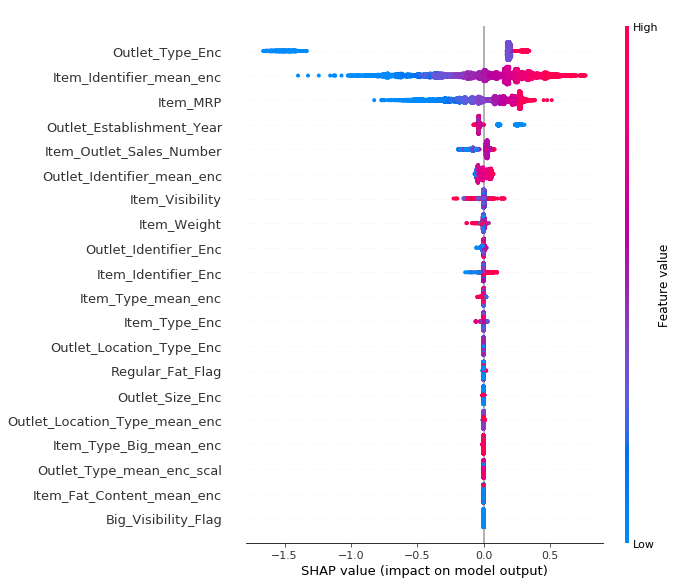

In [860]:
shap.summary_plot(sv.values, train_data[best_feats])

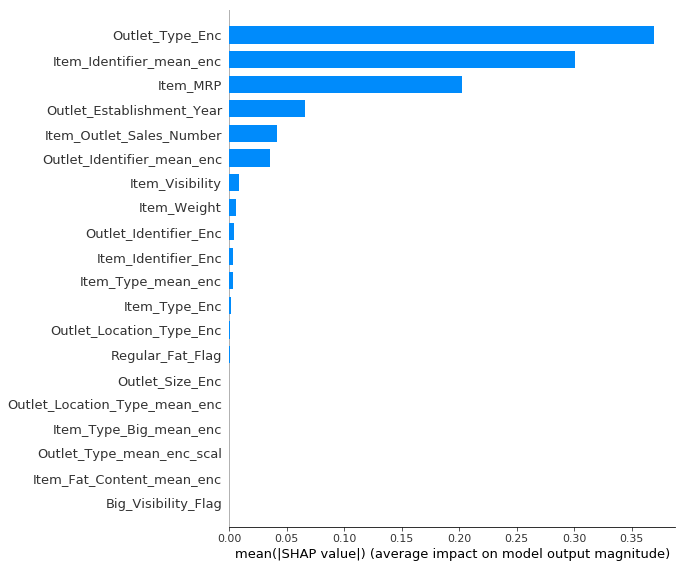

In [863]:
shap.summary_plot(sv.values, train_data[best_feats], plot_type='bar')

Интересно посмотреть на влияние Outlet_Type

In [896]:
cds = train_data[['Outlet_Type']]
cds['Outlet_Type_sv'] = sv['Outlet_Type_Enc']

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


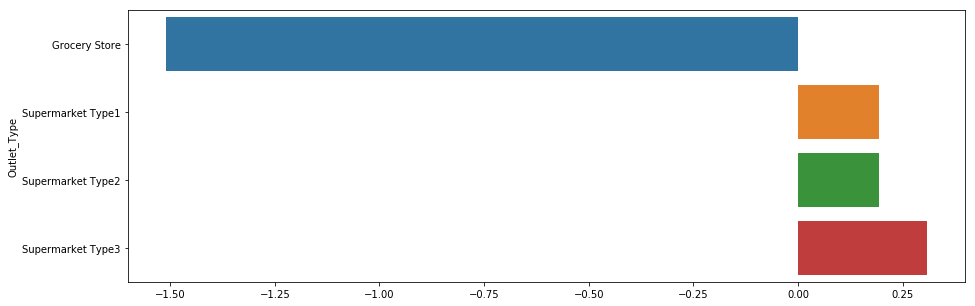

In [901]:
s = cds.groupby('Outlet_Type')['Outlet_Type_sv'].mean()
sns.barplot(x=s.values, y=s.index)

Как и было видно на графиках в секции EDA, продукты в Grocery Store продаются сильно хуже остальных магазинов. И это очень сильно влияет на продажи.

# Результаты

Самая лучшая модель на отложенной выборке:

In [964]:
res_ds = res_ds.sort_values('mae_test')
res_ds.head(1)

,name,mae_train,mae_test,r2_train,r2_test,features
4,svr_base,0.305952,0.440841,0.818544,0.687324,"Outlet_Location_Type__Tier 1,Outlet_Location_T..."


In [960]:
y_true = test_data[y_feat.replace('_log','')]
preds = np.expm1(best_base_model.predict(test_data[best_feats]))
mae = mean_absolute_error(y_true, preds)
mae, mae/y_true.mean()

(831.5496168306348, 0.38326251953436524)

In [965]:
res_ds['mae_test'].values[0]/test_data[y_feat].mean()

0.06051157575356751

* MAE для логарифмированной величины: 0.44 (6% от средних логарифмированных продаж)
* MAE для величины продаж: 831 (38% от средних продаж)

MAE для продаж довольно страшное. Попробуем обучить модель на исходной целевой переменной

In [1048]:
cb.fit(train_data[cb_feats], train_data['Item_Outlet_Sales'], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [1049]:
preds = cb.predict(test_data[cb_feats])
mae = mean_absolute_error(y_true, preds)
mae, mae/y_true.mean()

(802.2748351989268, 0.36976972687365744)

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


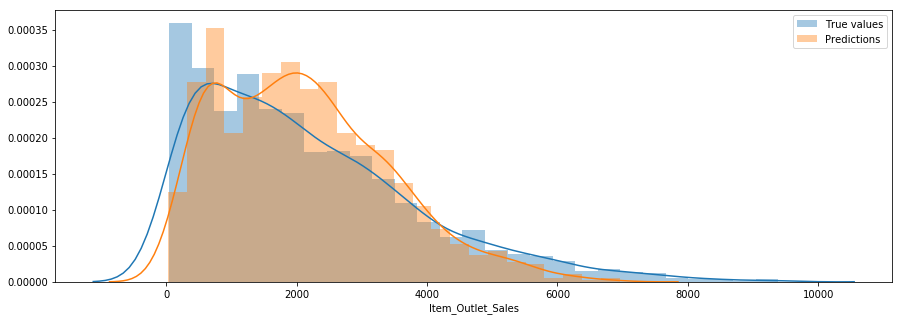

In [1050]:
sns.distplot(test_data[y_feat.replace('_log','')], label='True values')
sns.distplot(preds, label='Predictions')
plt.legend()

Наиболее важные признаки:
* Outlet_Type_Enc - тип магазина (Grocery или Supermarket)
* Item_Identifier_mean_enc - средние продажи товара во всех магазинах
* Item_MRP - максимальная цена товара

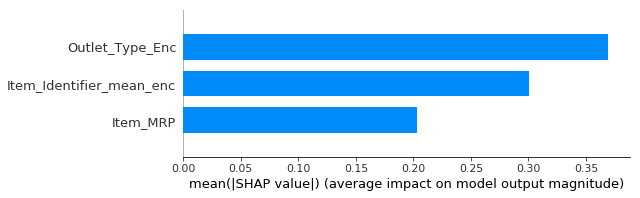

In [1056]:
shap.summary_plot(sv.values, train_data[best_feats], plot_type='bar', max_display=3)

In [1059]:
pd.concat([train_data, test_data]).to_csv('modified_dataset.csv')

Лучше всего на повышение продаж товара влияет:

    1) Размещение товара не в Grocery
    2) Максимальная цена товара
    3) Срок работы магазина
    4) Количество продаж товара (очевидно)
    5) Средние продажи в магазине
    6) Презентация товара на полках (влияет и в плюс и в минус, но как минимум она должна быть)
    7) и другие

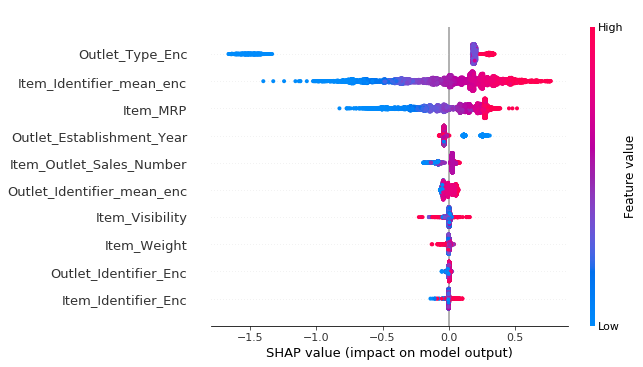

In [1060]:
shap.summary_plot(sv.values, train_data[best_feats], max_display=10)